# Hidden markov model (HMM)

The goal is to use to find looped and unlooped states in the data from single particle tracking of dual colors.

We will use Gaussian model for emission. 
Given all the data we fit the all the parameters (gaussian parameters, transition probability between looped/unlooped).

[//]: <> (Once we have the model, we use the model to predict the states on the datasets.)

[//]: <> (As control, we could use the TetO dual color control line -looped state and dual color in dCTCF and +auxin -unlooped state-)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hmmlearn import hmm
from matplotlib.backends.backend_pdf import PdfPages
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import gdown
import os
import pathlib
import zipfile

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

### Dual color imaging

To estimate the transition probability, we should have data without gaps. However we have gaps from time to time . To cope with this, we filled gaps using the distance of the first previous frame with no missing value. We allow maximum 20\% of tracks to be with missing values

In [3]:
fraction_nan_max = 0.2 # maximum fraction of gaps allowed 
reproducible = True
rolling = 0
if reproducible:
    np.random.seed(44)

From the experimental data we got an resolution limit of 100 +/- 50nm on distance. We will set the minimum diagonal of covariance matrix (error on the estimates) to be equal to 100nm (0.1).

### Model training

In [4]:
# sample_link = "https://drive.google.com/uc?export=download&id=1szF0P4OcA0X8WoPha5CKjo0sCLhJnrtX"
# if not os.path.isfile(f"{basedir}{dataset}.zip"):
#     gdown.download(sample_link, f"{basedir}{dataset}.zip")
# #unzip the data
# with zipfile.ZipFile(f"{basedir}{dataset}.zip", 'r') as zip_ref:
#     zip_ref.extractall(basedir)

# list_cell_lines = ["1B1", "1A2"]

basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/"
name = "two_colors_distance_30s"
acquisition = 30
dataset = f"{basedir}/211129_{name}.csv.zip"

sample_link = "https://drive.google.com/uc?export=download&id=1szF0P4OcA0X8WoPha5CKjo0sCLhJnrtX"
if not os.path.isfile(dataset):
    gdown.download(sample_link, dataset)

list_cell_lines = ["1B1"]


data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data = data[data.induction_time == "0min"]

exp_means = data.groupby("condition").mean()['distance']
exp_std = data.groupby("condition").std()['distance']

original = pd.DataFrame()
length = []
for _, sub in data.groupby("uniqueid"):
    sub, c = fill_gaps(sub, "frame")
    
    if c / len(sub) < fraction_nan_max:
        if rolling > 1:
            sub.distance = sub.distance.rolling(rolling, center=True).mean()
            sub.dropna(inplace=True)
        original = pd.concat([original, sub])
        length.append(len(sub))

print(f"Average datapoints across trajectories {np.mean(length)}")
data = original.copy()


traj = data["distance"].values
# hmm needs as input (obs, nfeatures)
traj2d = np.reshape((traj), (-1, 1))
lengths = data.uniqueid.value_counts()[data.uniqueid.unique()].values
print(f"\n Number of data points used in the model {traj2d.shape}")

# initiate model

nstates = 2
model = hmm.GaussianHMM(
    n_components=nstates,
    covariance_type="full",
    min_covar=0.1,
    n_iter=10000,
    params="mtc",
    init_params="mtc",
)

# instead of fitting
model.startprob_ = [1/nstates] * nstates
model.fit(traj2d)
# model.fit(traj2d, lengths=lengths)

means = model.means_
covars = model.covars_
sigmas = np.sqrt(model.covars_.squeeze())
w = np.array(model.transmat_)
logProb = model.score(traj2d)
print(f"\n Gaussian means: {means} \n ------")
print(f"Gaussian std: {sigmas} \n ------")
print(f"Transition rates: {w} \n ------")
print(f"logProg = {logProb} \n ------")
print(f"Starting probability = {model.startprob_} \n ------")

with open(f"{basedir}/hmmmodel_two_colors_distance_30s.obj", "wb") as file_model:
    pickle.dump(model, file_model)

Average datapoints across trajectories 252.52083333333334

 Number of data points used in the model (12121, 1)

 Gaussian means: [[0.1493922 ]
 [0.28807371]] 
 ------
Gaussian std: [0.0612939  0.13342964] 
 ------
Transition rates: [[0.95274362 0.04725638]
 [0.1461874  0.8538126 ]] 
 ------
logProg = 12888.998913084579 
 ------
Starting probability = [0.5 0.5] 
 ------


# Predict on samples and check the distribution of distances of the two states across samples

### Predict on 1B1 0 min

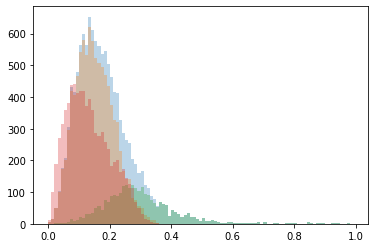

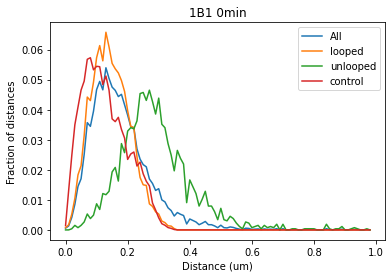

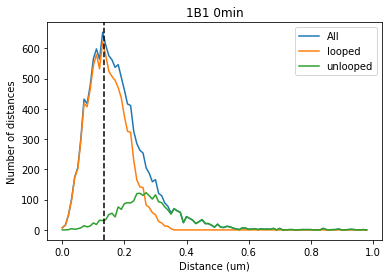

In [5]:
acquisition = '30'
pdf = PdfPages(f"{basedir}/hmm_gaussian_parameters_{acquisition}s.pdf")

res = pd.DataFrame()
for _, sub in data.groupby('uniqueid'):
    tmp = sub.copy()
    distance = sub.distance.values.reshape(-1, 1)
    states = (model.predict(distance))
    tmp['states'] = states
    res = pd.concat([tmp, res])
res["states_numeric"] = res.states.values
res.states.replace(0, "looped", inplace=True)
res.states.replace(1, "unlooped", inplace=True)
res["condition"] = res["cell_line"] + "_" + res["induction_time"]

res_limit = pd.read_csv("/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/control_lines_new/alldatapooled.csv")
res_limit = res_limit[res_limit.dist_cutoff == 0.3].copy()
res_limit.dropna(inplace=True)
hists = []

density=False
hist = plt.hist(res.distance, bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

hist=plt.hist(res.distance[res.states == "looped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

hist=plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

hist = plt.hist(res_limit.distance_after, bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/ np.sum(hist[0]))
plt.legend(["All", "looped", "unlooped", "control"])
plt.title("1B1 0min")
plt.xlabel("Distance (um)")
plt.ylabel("Fraction of distances")
pdf.savefig(fig)


fig = plt.figure()
for hist in hists[:-1]:
    plt.plot( hist[1][:-1], hist[0])
plt.legend(["All", "looped", "unlooped"])
plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.title("1B1 0min")
plt.xlabel("Distance (um)")
plt.ylabel("Number of distances")
pdf.savefig(fig)



In [6]:
a = res[["distance", "states"]].copy()
conversion = {"looped": "proximal", "unlooped":"distal"}
a["states"] = [conversion[x] for x in a["states"]]

res_limit["states"] = "colocalized_control_line"
b = res_limit[["distance_after", "states"]].copy()
b.columns = ["distance", "states"]
 
out = pd.concat([a,b])
out.to_csv("Figure5B.csv", index=False)

Text(0, 0.5, 'Number of distances')

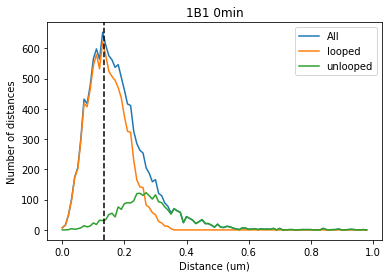

In [7]:
for hist in hists[:-1]:
    plt.plot( hist[1][:-1], hist[0])
plt.legend(["All", "looped", "unlooped"])
plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.title("1B1 0min")
plt.xlabel("Distance (um)")
plt.ylabel("Number of distances")

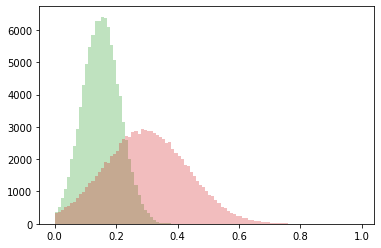

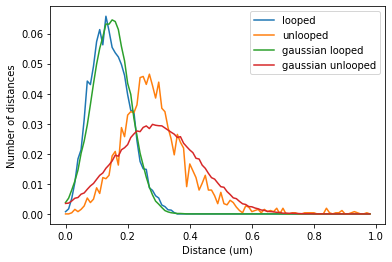

In [8]:
# how good are looped and unlooped state approx in terms of gaussian?
g1 = np.random.normal(0.15143499, 0.06173417, 100000)
g2 = np.random.normal(0.29465796, 0.13791336, 100000)

hists = []
hist=plt.hist(res.distance[res.states == "looped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(g1, bins = np.arange(0, 1, 0.01), alpha = 0.3)
hists.append(hist)

hist=plt.hist(g2, bins = np.arange(0, 1, 0.01), alpha = 0.3)
hists.append(hist)


fig = plt.figure()
for hist in hists:
    plt.plot(hist[1][:-1], hist[0]/ np.sum(hist[0]))
plt.legend(["looped", "unlooped", "gaussian looped", "gaussian unlooped"])
plt.xlabel("Distance (um)")
plt.ylabel("Number of distances")
pdf.savefig(fig)

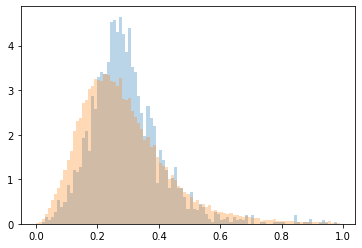

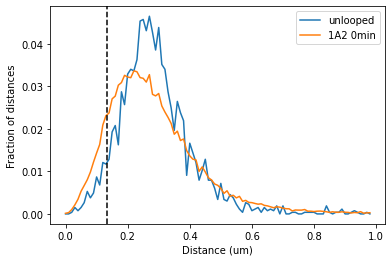

In [9]:
list_cell_lines = ["1A2"]

data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data = data[data.induction_time == "0min"]

fig = plt.figure()
hists = []

hist = plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist = plt.hist(data.distance, bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))

plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.legend(["unlooped", "1A2 0min"])
plt.ylabel("Fraction of distances")
plt.xlabel("Distance (um)")
pdf.savefig(fig)

In [10]:
a = pd.DataFrame(res.distance[res.states == "unlooped"])
a["condition"] = "'distal +CTCF+RAD21'"
b = data[["distance", "condition"]]
b["condition"] = "''-CTCF+RAD21'"
pd.concat([a,b]).to_csv("FigureS5D.csv", index=False)

/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


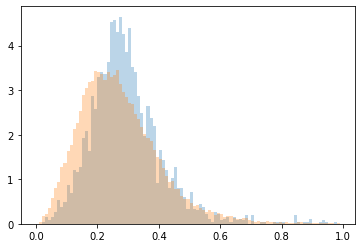

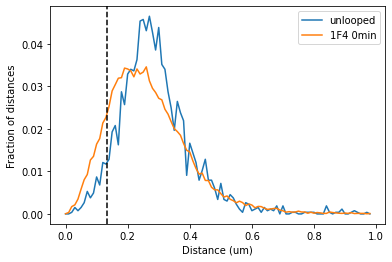

In [11]:
list_cell_lines = ["1F4"]

data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data = data[data.induction_time == "0min"]

fig = plt.figure()
hists = []

hist = plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist = plt.hist(data.distance, bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))

plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.legend(["unlooped", "1F4 0min"])
plt.ylabel("Fraction of distances")
plt.xlabel("Distance (um)")
pdf.savefig(fig)

### What is the difference between 1A2/1B1 120min and unlooped state?


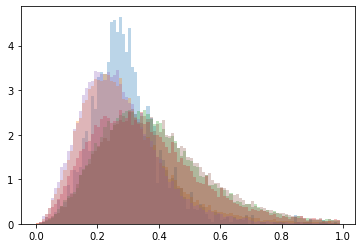

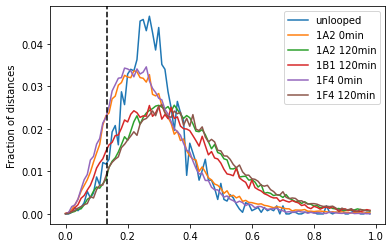

In [12]:
list_cell_lines = ["1A2", "1B1", "1F4"]

data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data['condition'] = data['cell_line'] + "_" + data['induction_time']

exp_means = data.groupby("condition").mean()['distance']
exp_std = data.groupby("condition").std()['distance']

fig = plt.figure()
hists = []

hist = plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist= plt.hist(data.distance[data['condition'] == "1A2_0min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(data.distance[data['condition'] == "1A2_120min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(data.distance[data['condition'] == "1B1_120min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist= plt.hist(data.distance[data['condition'] == "1F4_0min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(data.distance[data['condition'] == "1F4_120min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))

plt.legend(["unlooped", "1A2 0min", "1A2 120min", "1B1 120min",  "1F4 0min", "1F4 120min"])
plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.ylabel("Fraction of distances")
pdf.savefig(fig)

In [13]:
a = data[["distance", "condition"]]
a = a[a["condition"].isin(["1F4_0min","1F4_120min", "1A2_0min","1A2_120min"])]
conversion = {"1F4_0min": "'+promoter+RAD21'","1F4_120min": "'+promoter-RAD21'", "1A2_0min": "'-promoter+RAD21'","1A2_120min": "'-promoter-RAD21'"}
a["condition"] = [conversion[x] for x in a["condition"]]
a.to_csv("FigureS5F.csv", index=False)


### what are the contact duration and second passage time?

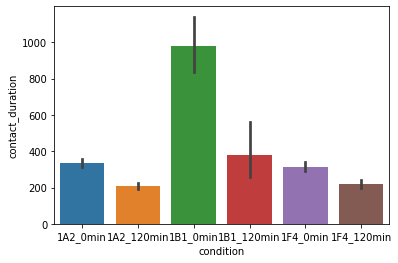

In [14]:
from utils import *
list_cell_lines = ["1A2", "1B1", "1F4"]

data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data["condition"] = data["cell_line"] + "_" + data["induction_time"]

hue_order = sorted(data["condition"].unique())
(
    original_durations,
    original_second_passage_times,
    _,
    fraction_time,
    conditions,
    data_filtered_original,
) = calculate_duration_second_passage_time(
    data=data,
    resolution=30,
    model=model,
    fraction_nan_max=0.2,
)

# Contact duration
fig = plt.figure()
box_plot = sns.barplot(data=original_durations, x="condition", y="contact_duration", hue_order=hue_order)
plt.show()
pdf.savefig(box_plot.figure)

In [15]:
conversion = {"1B1_0min": "'+CTCF +RAD21'", "1B1_120min": "'+CTCF -RAD21'", "1A2_0min": "'-CTCF +RAD21'", "1A2_120min": "'-CTCF -RAD21'"}
a = original_durations.loc[original_durations.condition.isin(["1B1_0min", "1B1_120min", "1A2_0min", "1A2_120min"]), ["contact_duration", "condition"]].copy()
a["condition"] = [conversion[x] for x in a["condition"]]
a.to_csv("Figure5D.csv", index=False)

In [16]:
a.condition.value_counts()

'-CTCF +RAD21'    680
'+CTCF +RAD21'    287
'-CTCF -RAD21'    268
'+CTCF -RAD21'    114
Name: condition, dtype: int64

In [17]:
conversion = {"1F4_0min": "'+promoter +RAD21'", "1F4_120min": "'+promoter -RAD21'", "1A2_0min": "'-promoter +RAD21'", "1A2_120min": "'-promoter -RAD21'"}
a = original_durations.loc[original_durations.condition.isin(["1F4_0min", "1F4_120min", "1A2_0min", "1A2_120min"]), ["contact_duration", "condition"]].copy()
a["condition"] = [conversion[x] for x in a["condition"]]
a.to_csv("FigureS5H.csv", index=False)

In [18]:
a.condition.value_counts()

'-promoter +RAD21'    680
'+promoter +RAD21'    466
'-promoter -RAD21'    268
'+promoter -RAD21'    253
Name: condition, dtype: int64

In [29]:
import scipy
import scipy.stats
list_conditions = original_durations.condition.unique()
for i in range(len(list_conditions)):
    for j in range(i + 1, len(list_conditions)):
        test = scipy.stats.ks_2samp(
            original_durations.contact_duration[original_durations.condition == list_conditions[i]].values,
            original_durations.contact_duration[original_durations.condition == list_conditions[j]].values,
        )
        print(f"{list_conditions[i]} vs {list_conditions[j]} p-value pfrom two sided t.test {test.pvalue}")



1A2_0min vs 1A2_120min p-value pfrom two sided t.test 2.8754776337791554e-14
1A2_0min vs 1B1_0min p-value pfrom two sided t.test 2.1094237467877974e-15
1A2_0min vs 1B1_120min p-value pfrom two sided t.test 0.03842075427631464
1A2_0min vs 1F4_0min p-value pfrom two sided t.test 0.6027255554620128
1A2_0min vs 1F4_120min p-value pfrom two sided t.test 6.371000393912141e-10
1A2_120min vs 1B1_0min p-value pfrom two sided t.test 9.992007221626409e-16
1A2_120min vs 1B1_120min p-value pfrom two sided t.test 0.01350208463146163
1A2_120min vs 1F4_0min p-value pfrom two sided t.test 7.427788384362088e-10
1A2_120min vs 1F4_120min p-value pfrom two sided t.test 0.8334437574638154
1B1_0min vs 1B1_120min p-value pfrom two sided t.test 1.3675283128122828e-11
1B1_0min vs 1F4_0min p-value pfrom two sided t.test 4.440892098500626e-16
1B1_0min vs 1F4_120min p-value pfrom two sided t.test 2.220446049250313e-16
1B1_120min vs 1F4_0min p-value pfrom two sided t.test 0.19433128315407833
1B1_120min vs 1F4_120mi

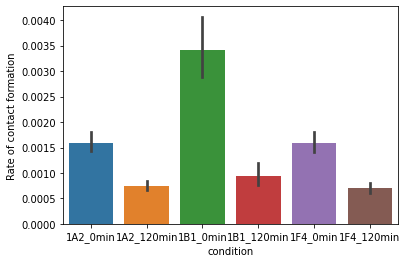

In [19]:
# rate of contact formation
fig = plt.figure()
box_plot = sns.barplot(data=original_second_passage_times, x="condition", y="second_passage_time", estimator = lambda x: 1/np.mean(x))
plt.ylabel("Rate of contact formation")
plt.show()
pdf.savefig(box_plot.figure, bbox_inches='tight')

In [20]:
conversion = {"1B1_0min": "'+CTCF +RAD21'", "1B1_120min": "'+CTCF -RAD21'", "1A2_0min": "'-CTCF +RAD21'", "1A2_120min": "'-CTCF -RAD21'"}
a = original_second_passage_times.loc[original_second_passage_times.condition.isin(["1B1_0min", "1B1_120min", "1A2_0min", "1A2_120min"]), ["second_passage_time", "condition"]].copy()
a["condition"] = [conversion[x] for x in a["condition"]]
a.to_csv("Figure5E.csv", index=False)

In [21]:
a.condition.value_counts()

'-CTCF +RAD21'    726
'-CTCF -RAD21'    323
'+CTCF +RAD21'    268
'+CTCF -RAD21'    138
Name: condition, dtype: int64

In [22]:
conversion = {"1F4_0min": "'+promoter +RAD21'", "1F4_120min": "'+promoter -RAD21'", "1A2_0min": "'-promoter +RAD21'", "1A2_120min": "'-promoter -RAD21'"}
a = original_second_passage_times.loc[original_second_passage_times.condition.isin(["1F4_0min", "1F4_120min", "1A2_0min", "1A2_120min"]), ["second_passage_time", "condition"]].copy()
a["condition"] = [conversion[x] for x in a["condition"]]
a.to_csv("FigureS5I.csv", index=False)

In [23]:
a.condition.value_counts()

'-promoter +RAD21'    726
'+promoter +RAD21'    495
'-promoter -RAD21'    323
'+promoter -RAD21'    296
Name: condition, dtype: int64

In [24]:
list_conditions = original_second_passage_times.condition.unique()
for i in range(len(list_conditions)):
    for j in range(i + 1, len(list_conditions)):
        test = scipy.stats.ks_2samp(
            original_second_passage_times.second_passage_time[original_second_passage_times.condition == list_conditions[i]].values,
            original_second_passage_times.second_passage_time[original_second_passage_times.condition == list_conditions[j]].values,
        )
        print(f"{list_conditions[i]} vs {list_conditions[j]} p-value pfrom two sided t.test {test.pvalue}")


1A2_0min vs 1A2_120min p-value pfrom two sided t.test 0.0
1A2_0min vs 1B1_0min p-value pfrom two sided t.test 4.618216919993756e-11
1A2_0min vs 1B1_120min p-value pfrom two sided t.test 0.0027488009797244084
1A2_0min vs 1F4_0min p-value pfrom two sided t.test 0.7630364503479828
1A2_0min vs 1F4_120min p-value pfrom two sided t.test 5.824158212509372e-16
1A2_120min vs 1B1_0min p-value pfrom two sided t.test 6.146289237907388e-28
1A2_120min vs 1B1_120min p-value pfrom two sided t.test 0.01840998541174177
1A2_120min vs 1F4_0min p-value pfrom two sided t.test 3.58268970046538e-13
1A2_120min vs 1F4_120min p-value pfrom two sided t.test 0.448030857735514
1B1_0min vs 1B1_120min p-value pfrom two sided t.test 8.596057199383722e-11
1B1_0min vs 1F4_0min p-value pfrom two sided t.test 1.640125812940596e-10
1B1_0min vs 1F4_120min p-value pfrom two sided t.test 1.0981701644777496e-26
1B1_120min vs 1F4_0min p-value pfrom two sided t.test 0.015386124808674961
1B1_120min vs 1F4_120min p-value pfrom two

##### Fano factor calculation

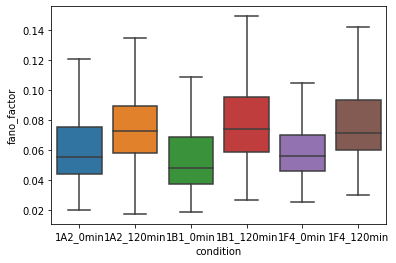

In [25]:
cell_lines = ["1B1", "1A2", "2C11", "1F4"]
induction_times = ["0min", "120min"]
correction_type = ["cellIDs_uncorrected"]
res = data[(data.cell_line.isin(cell_lines)) & (data.induction_time.isin(induction_times)) & (data.motion_correction_type.isin(correction_type))]

res.loc['condition'] = res.cell_line + "_" +res.induction_time

legend = []
ffs = pd.DataFrame()
for name, sub in res.groupby("condition"):
    fano_factor = []
    for _, s in sub.groupby("uniqueid"):
        fano_factor.append(s.distance.var()/ abs(s.distance.mean()))
    tmp = pd.DataFrame(fano_factor, columns=["fano_factor"])
    tmp["condition"] = name
    
    ffs = pd.concat([ffs, tmp])
fig = plt.figure()
sns.boxplot(data = ffs, x="condition", y="fano_factor", showfliers = False)
pdf.savefig(fig)

In [26]:
list_conditions = ffs.condition.unique()
for i in range(len(list_conditions)):
    for j in range(i + 1, len(list_conditions)):
        test = scipy.stats.ks_2samp(
            ffs.fano_factor[ffs.condition == list_conditions[i]].values,
            ffs.fano_factor[ffs.condition == list_conditions[j]].values,
        )
        print(f"{list_conditions[i]} vs {list_conditions[j]} p-value pfrom two sided t.test {test.pvalue}")

1A2_0min vs 1A2_120min p-value pfrom two sided t.test 5.675238057278875e-12
1A2_0min vs 1B1_0min p-value pfrom two sided t.test 0.005942749082149756
1A2_0min vs 1B1_120min p-value pfrom two sided t.test 1.0962453167451258e-11
1A2_0min vs 1F4_0min p-value pfrom two sided t.test 0.419198154382471
1A2_0min vs 1F4_120min p-value pfrom two sided t.test 5.203726338720571e-12
1A2_120min vs 1B1_0min p-value pfrom two sided t.test 3.3306690738754696e-16
1A2_120min vs 1B1_120min p-value pfrom two sided t.test 0.23699992506935008
1A2_120min vs 1F4_0min p-value pfrom two sided t.test 5.6673998827250216e-11
1A2_120min vs 1F4_120min p-value pfrom two sided t.test 0.8761586079044198
1B1_0min vs 1B1_120min p-value pfrom two sided t.test 2.5424107263916085e-14
1B1_0min vs 1F4_0min p-value pfrom two sided t.test 0.000498453819730682
1B1_0min vs 1F4_120min p-value pfrom two sided t.test 6.661338147750939e-16
1B1_120min vs 1F4_0min p-value pfrom two sided t.test 2.971859425215939e-10
1B1_120min vs 1F4_120

### Fraction of time spent in each state

In [30]:
# fig = plt.figure()

means = []
stds = []
conditions = []
for condition, dataset in data_filtered_original.groupby("condition"):
    tmp = []
    for i in range(10000):
        tmp.append(
            1 - np.mean(dataset.prediction.values[
                np.random.choice(
                    range(len(dataset)), size=int(len(dataset)*0.05), replace=True
                )
            ])
        )
    means.append(np.mean(tmp))
    stds.append(np.std(tmp))
    conditions.append(condition)


In [31]:
a = pd.DataFrame(means)
a.columns = ["mean"]
a["std"] = stds
a["condition"] = conditions
a = a[a["condition"].isin(["1F4_0min", "1F4_120min", "1A2_0min", "1A2_120min"])]

conversion = {"1F4_0min": "'+promoter +RAD21'", "1F4_120min": "'+promoter -RAD21'", "1A2_0min": "'-promoter +RAD21'", "1A2_120min": "'-promoter -RAD21'"}
a["condition"] = [conversion[x] for x in a["condition"]]
a.to_csv("FigureS5G.csv")

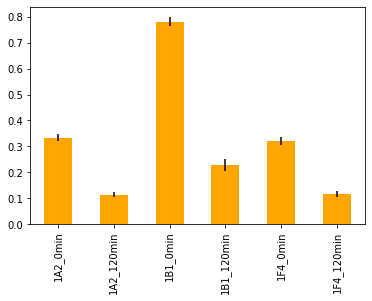

In [32]:
fig=plt.figure()

time_spent = pd.DataFrame(means, index = conditions)
time_spent.columns = ["mean"]
time_spent["std"] = stds

mm = time_spent["mean"]
std = time_spent["std"]

mm.plot(kind="bar", yerr=std, color="orange")

pdf.savefig(fig)

### What are the gaussian mean and standard deviation of the fitted model?

In [33]:
df = pd.DataFrame(model.means_, columns=["Gaussian_means"])
df["Gaussian_std"] = sigmas
df["imaging_type"] = "30s"
df["state"] = ["looped", "unlooped"]

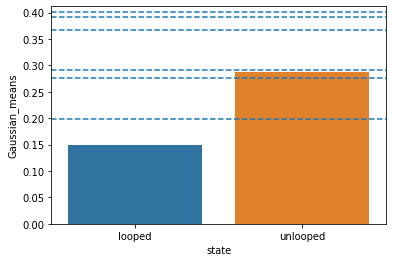

In [34]:
fig = sns.barplot(data = df, y="Gaussian_means", x="state")
for value in exp_means:
    plt.axhline(y=value, linestyle='--')
pdf.savefig(fig.figure)

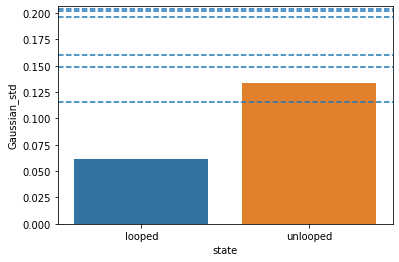

In [35]:
fig = sns.barplot(data = df, y="Gaussian_std", x="state")
for value in exp_std:
    plt.axhline(y=value, linestyle='--')
pdf.savefig(fig.figure)

In [36]:
pdf.close()

In [37]:
pdf = PdfPages(f"{basedir}/trajectories_{acquisition}s.pdf")
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/"
name = "two_colors_distance_30s"
acquisition = 30
dataset = f"{basedir}/211129_{name}.csv.zip"
data = pd.read_csv(dataset)

cell_lines = ["1B1", "1A2"]
induction_times = ["0min", "120min"]

data = data[(data.cell_line).isin(cell_lines) & (data.induction_time).isin(induction_times)]

/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


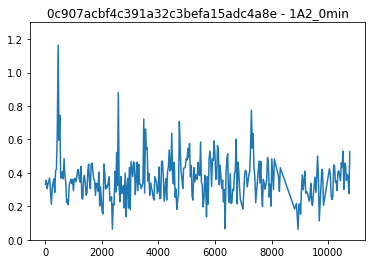

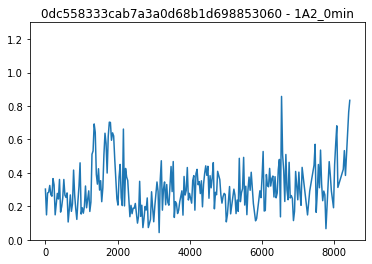

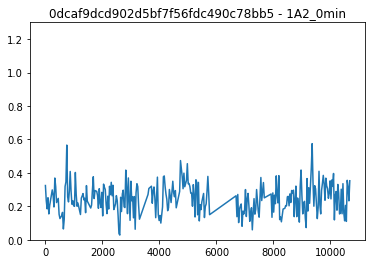

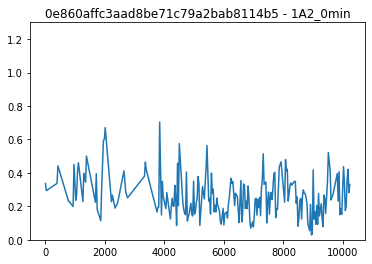

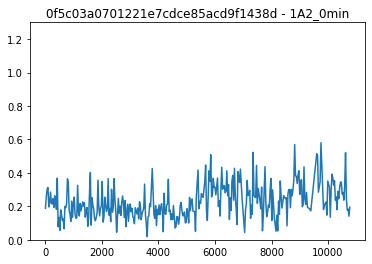

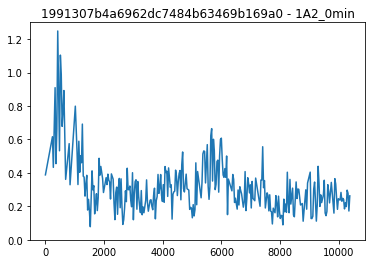

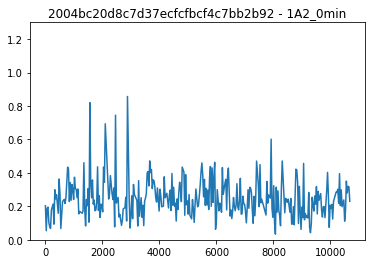

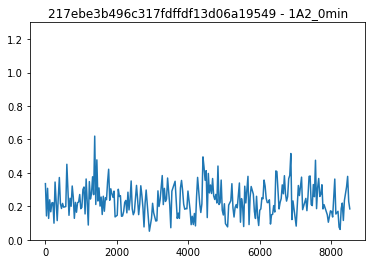

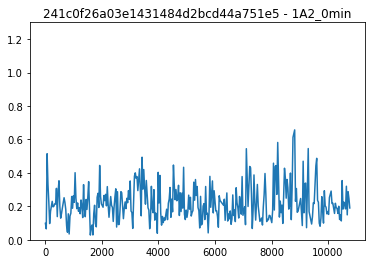

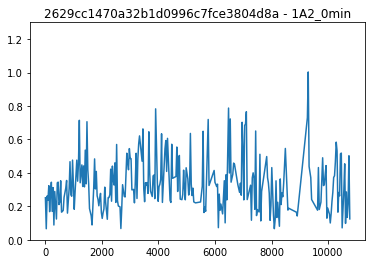

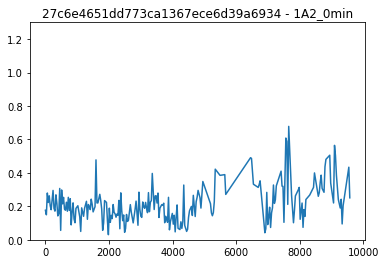

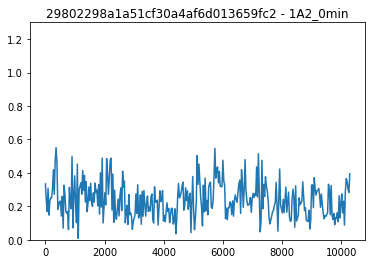

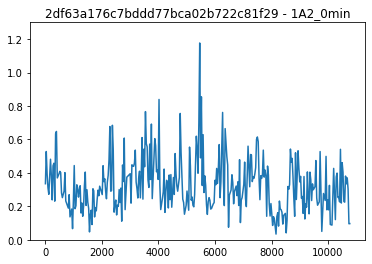

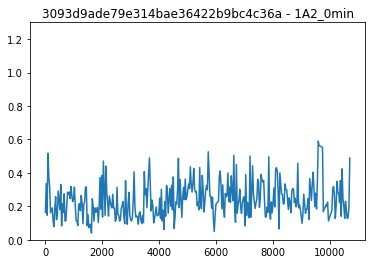

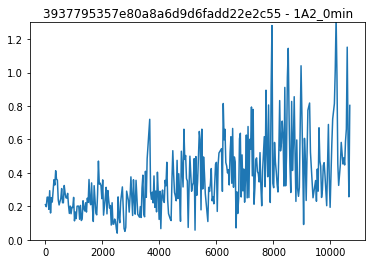

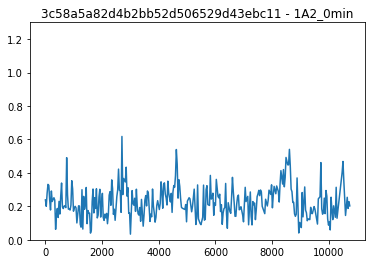

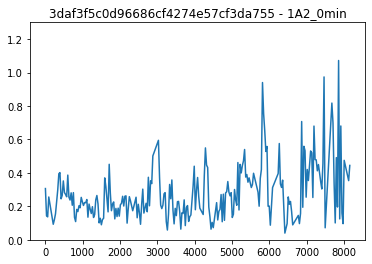

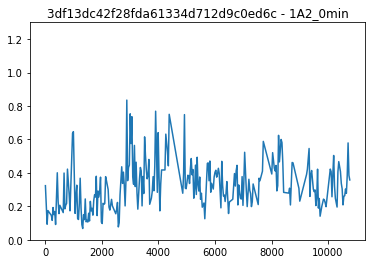

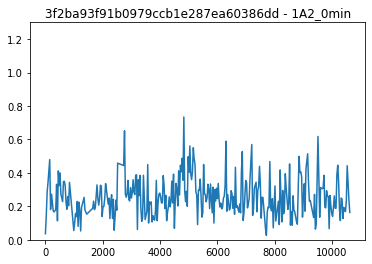

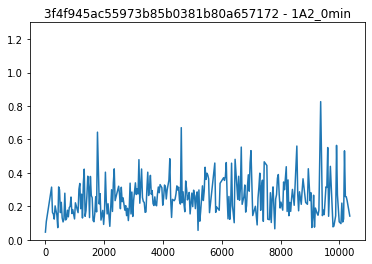

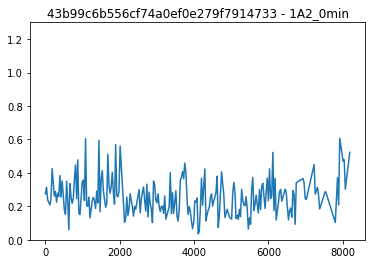

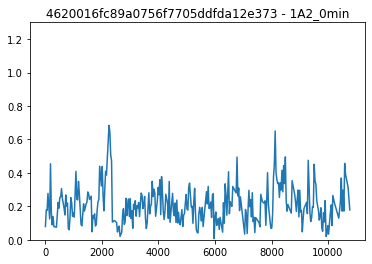

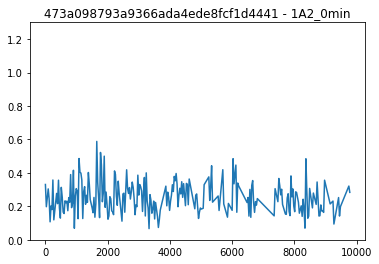

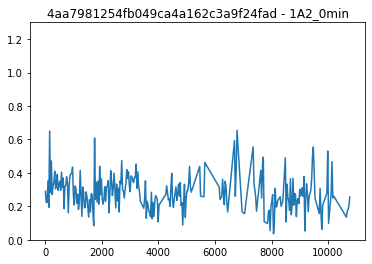

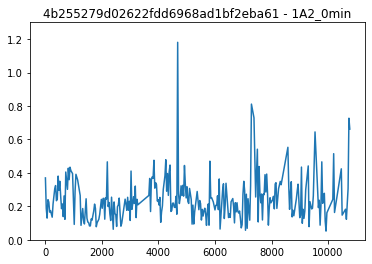

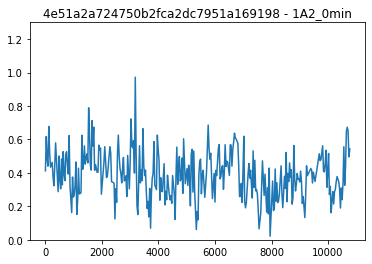

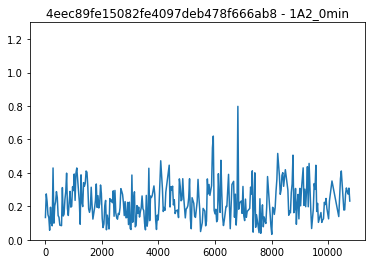

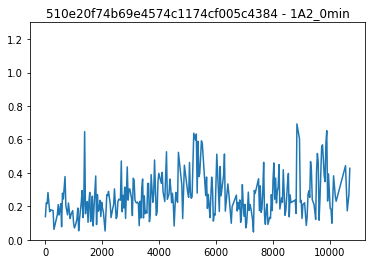

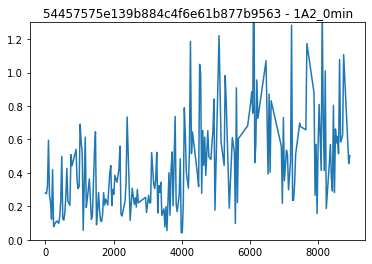

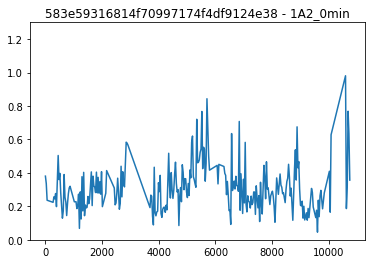

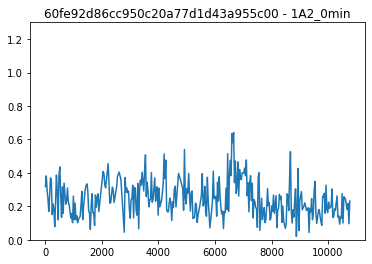

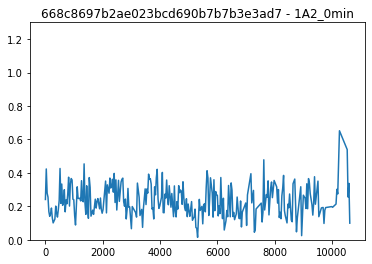

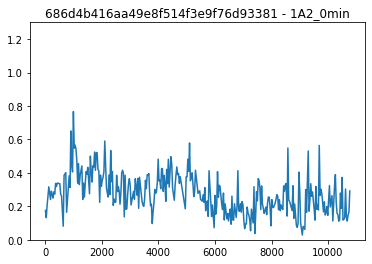

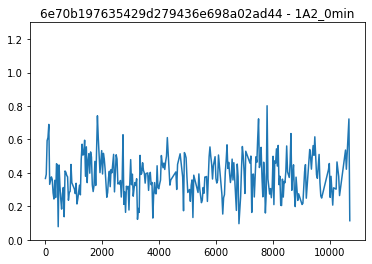

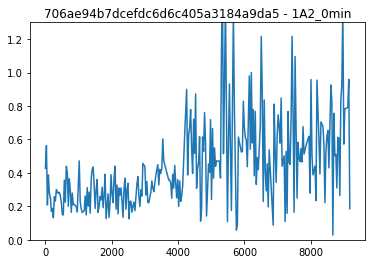

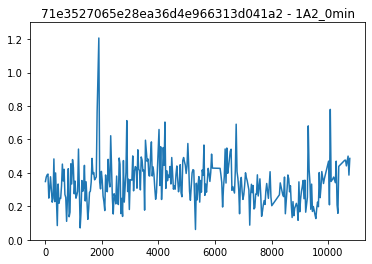

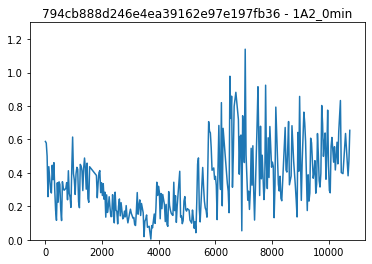

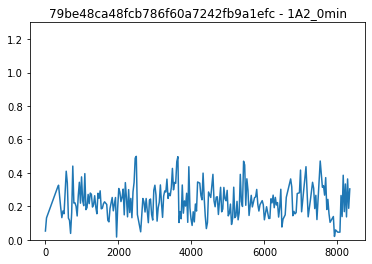

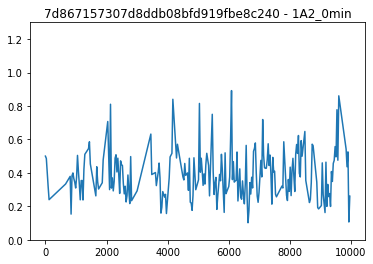

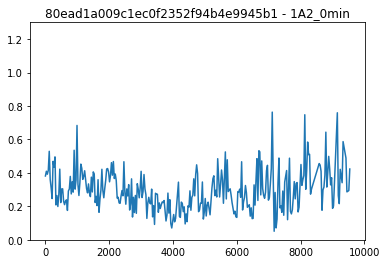

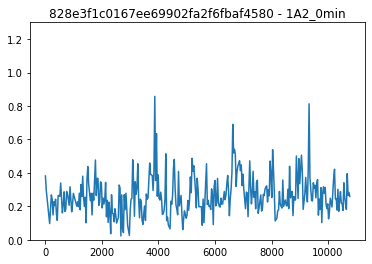

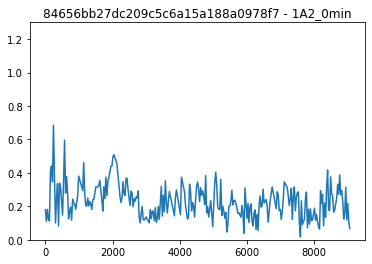

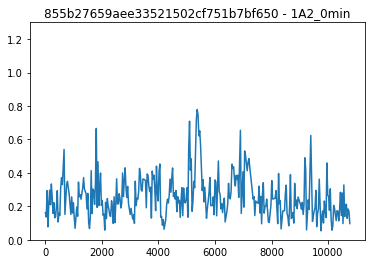

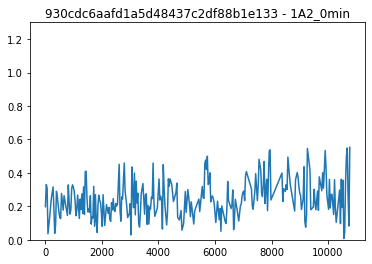

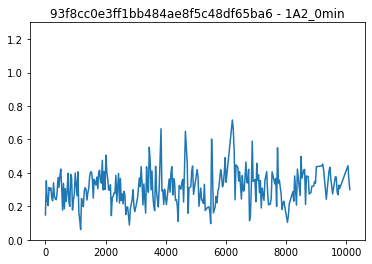

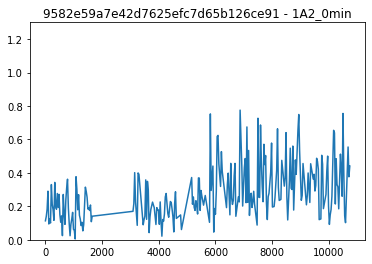

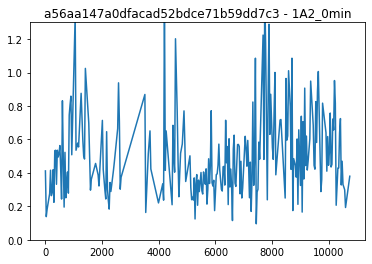

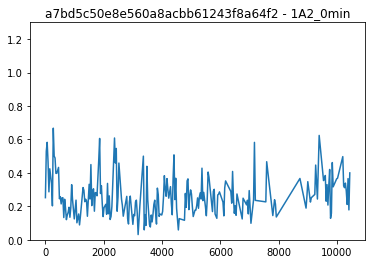

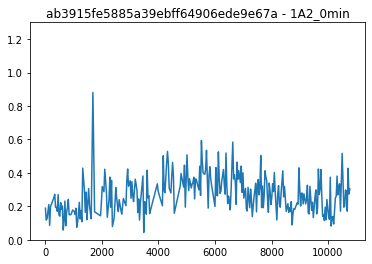

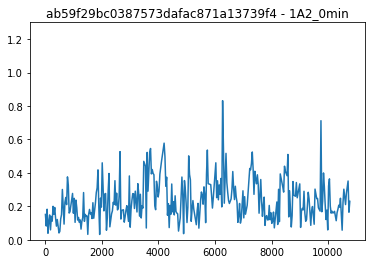

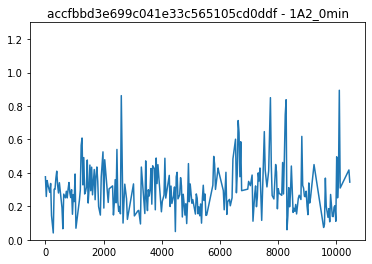

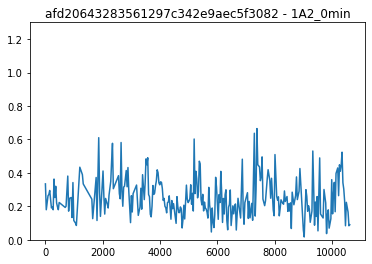

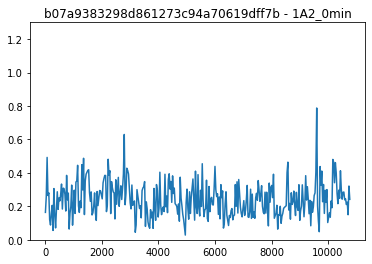

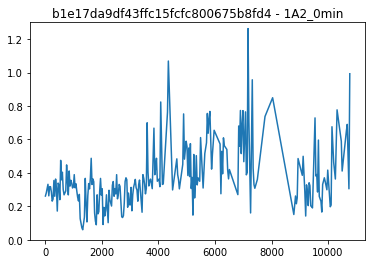

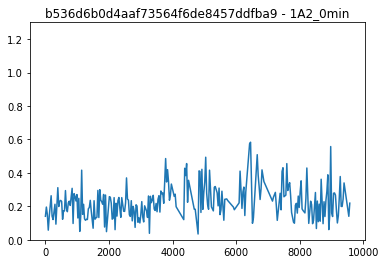

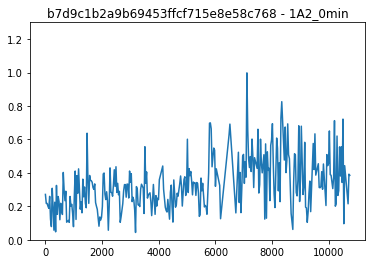

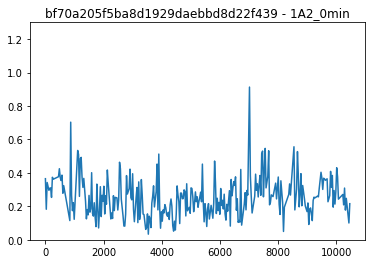

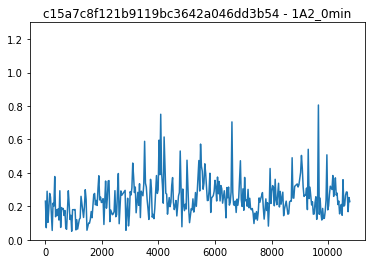

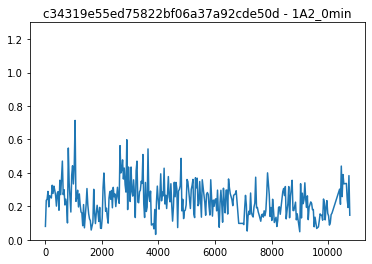

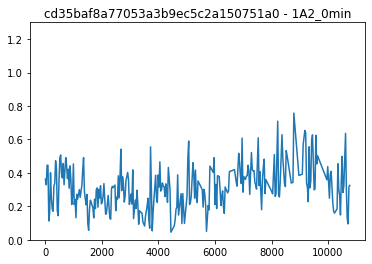

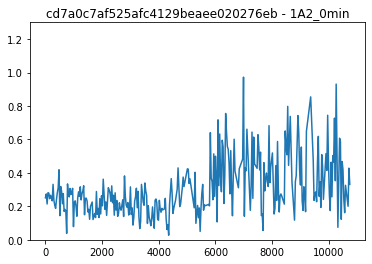

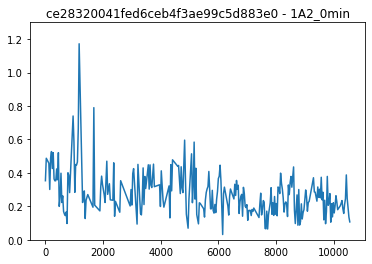

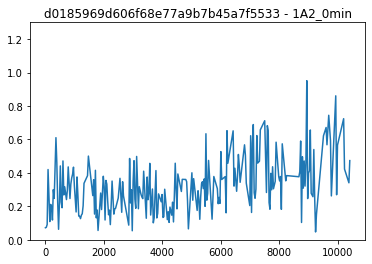

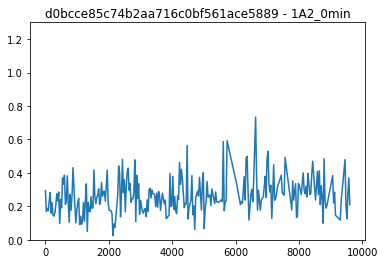

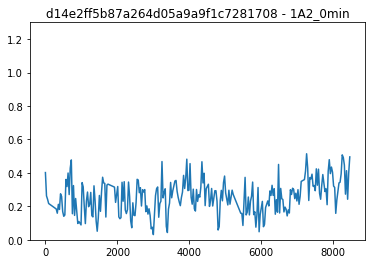

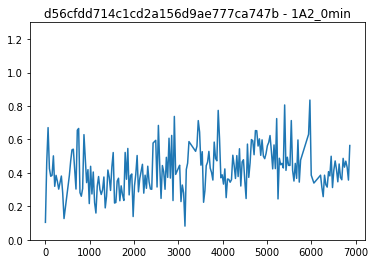

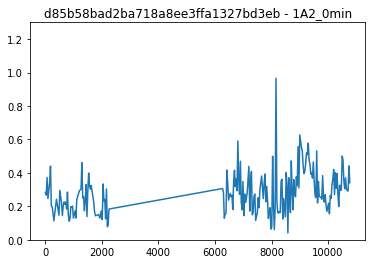

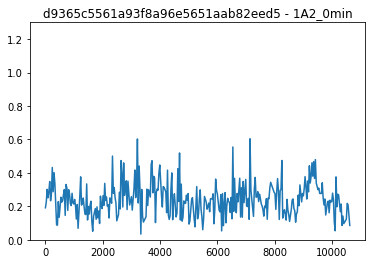

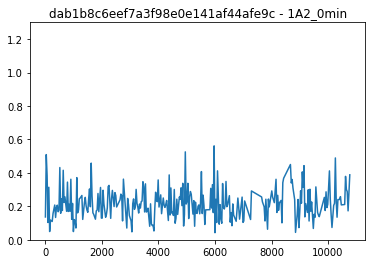

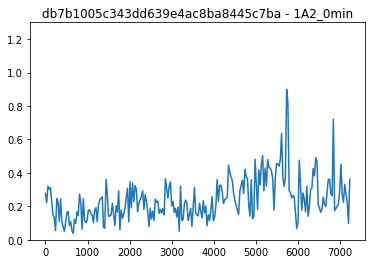

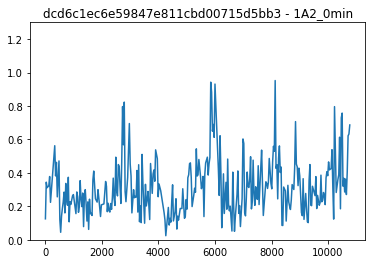

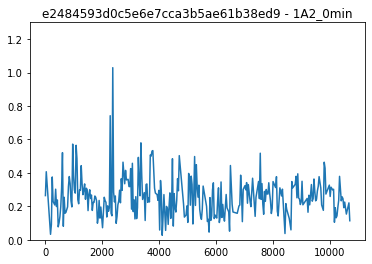

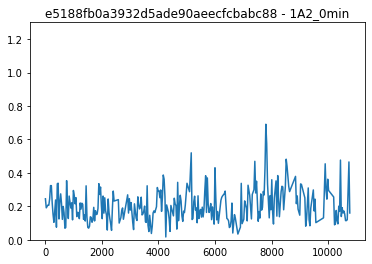

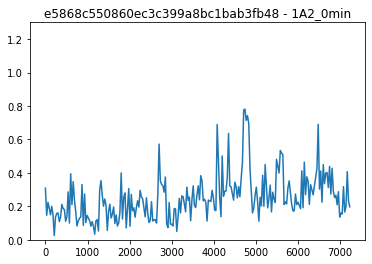

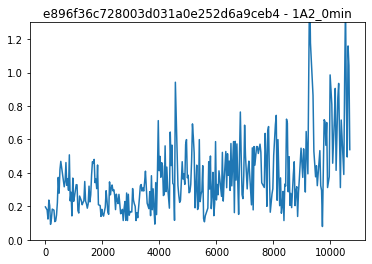

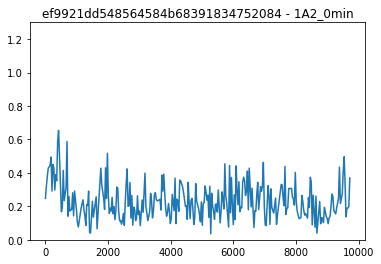

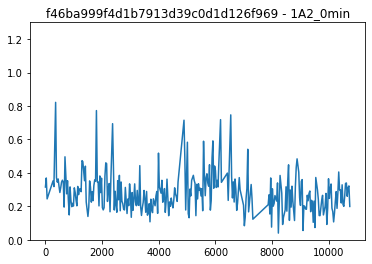

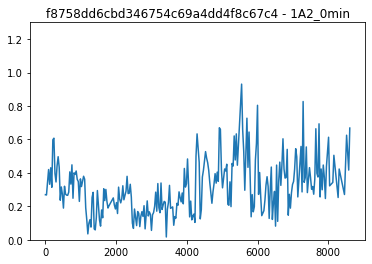

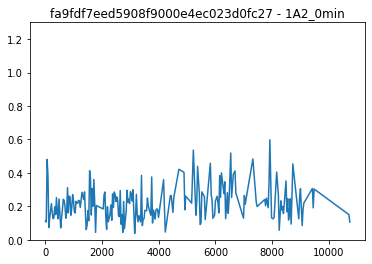

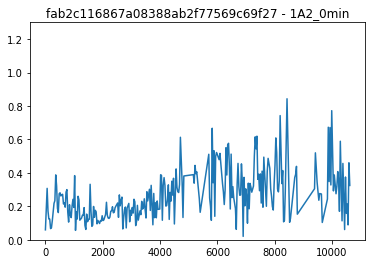

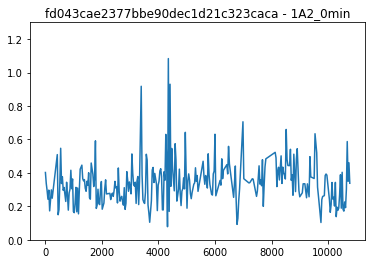

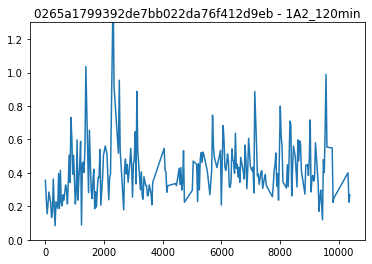

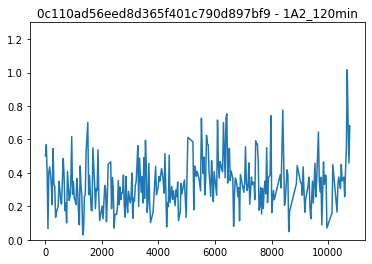

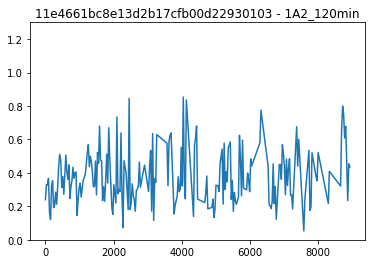

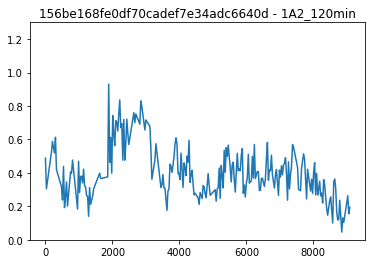

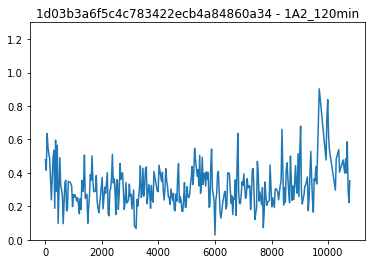

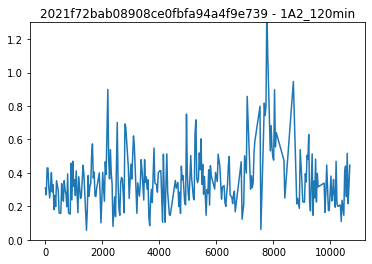

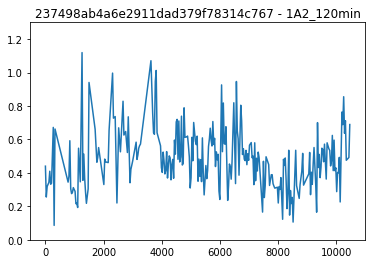

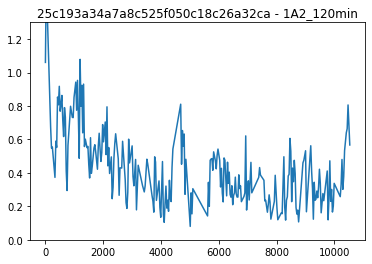

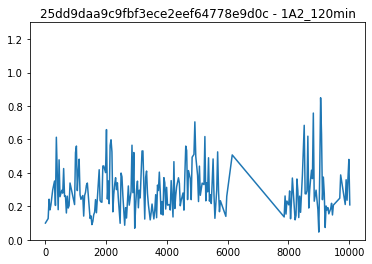

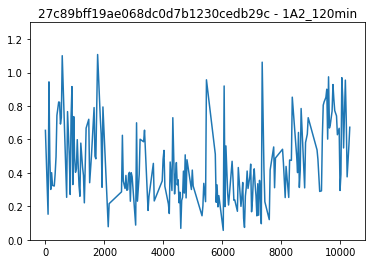

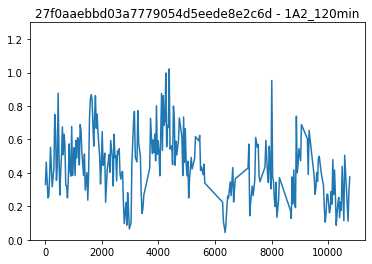

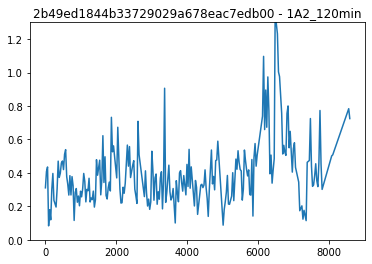

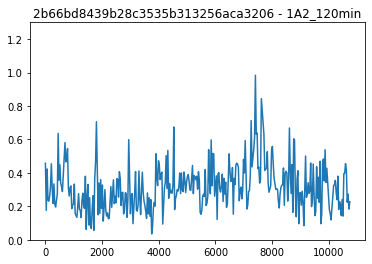

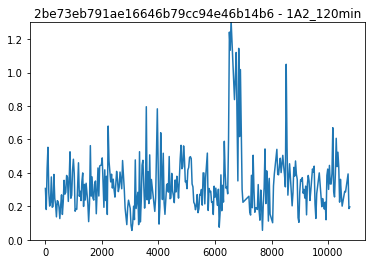

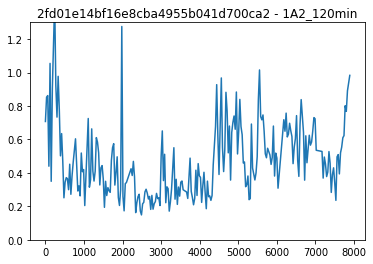

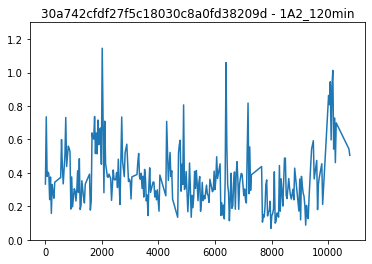

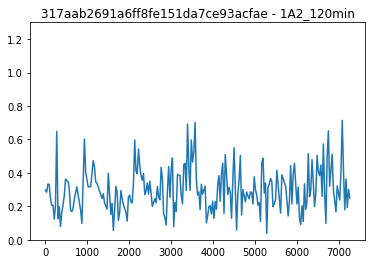

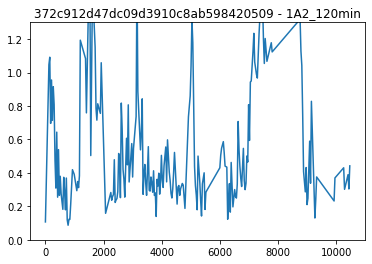

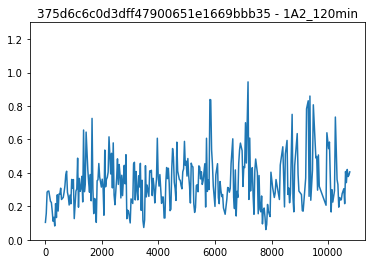

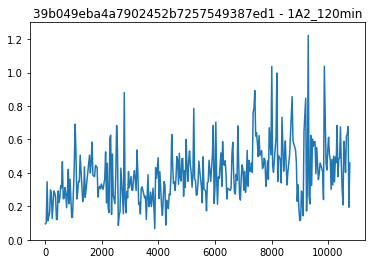

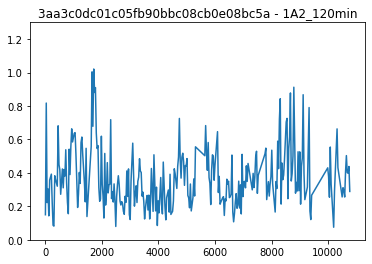

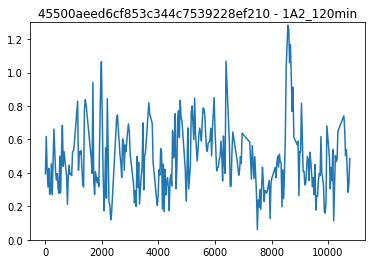

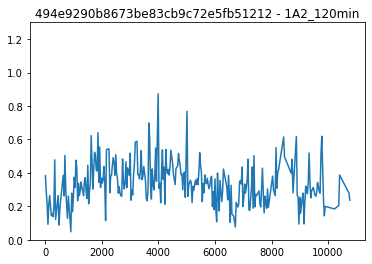

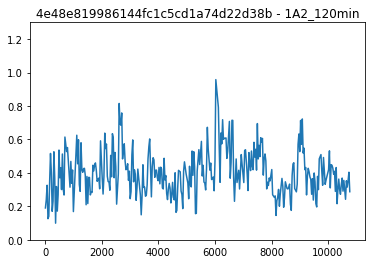

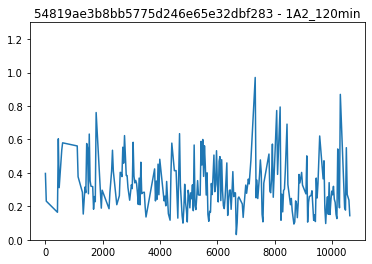

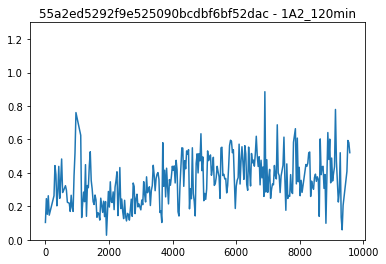

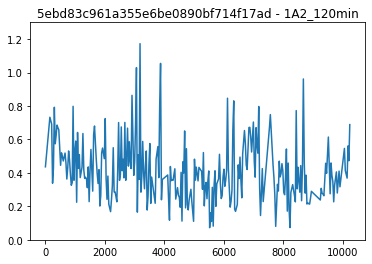

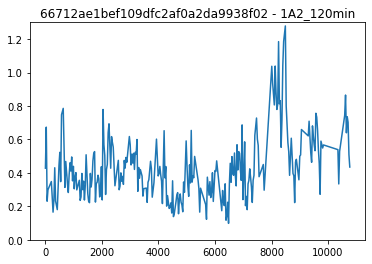

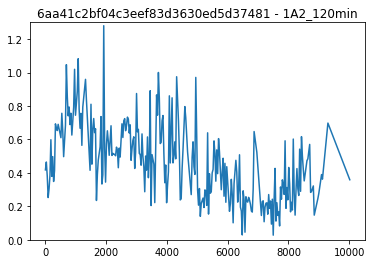

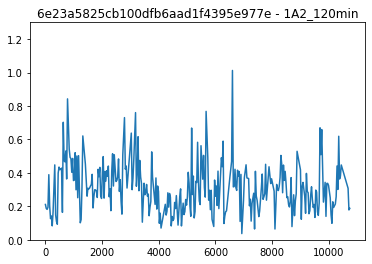

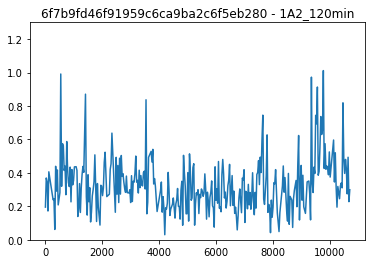

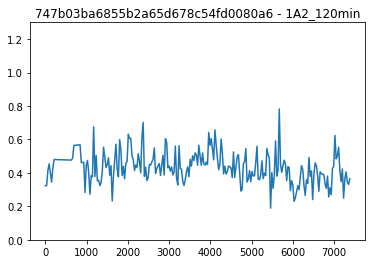

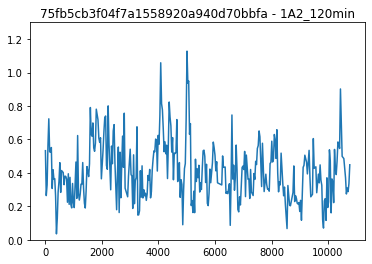

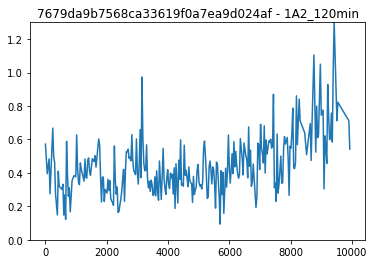

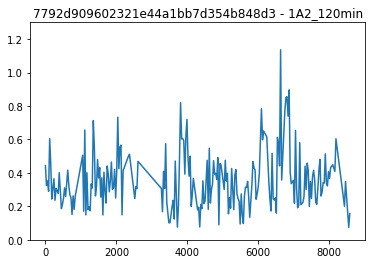

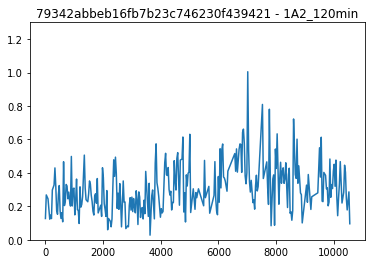

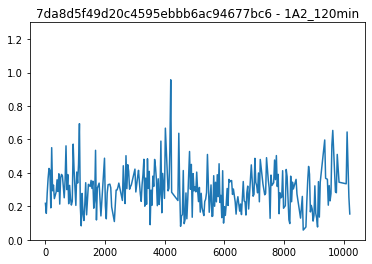

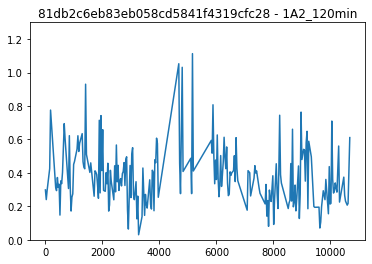

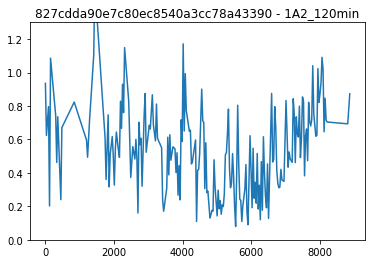

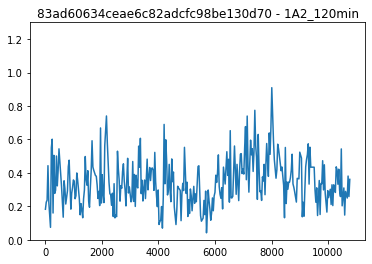

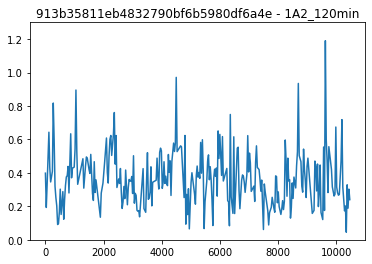

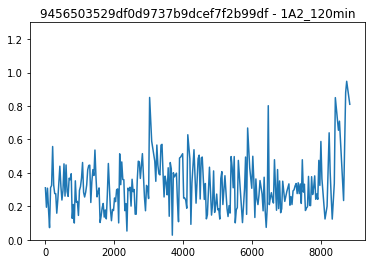

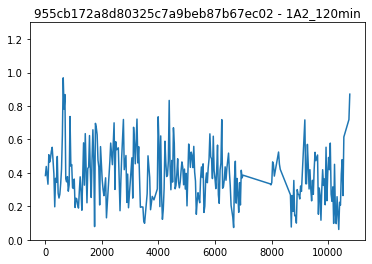

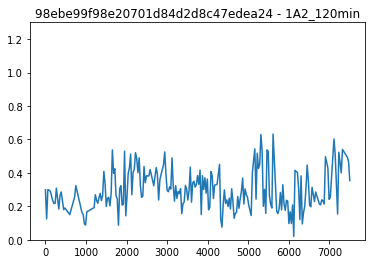

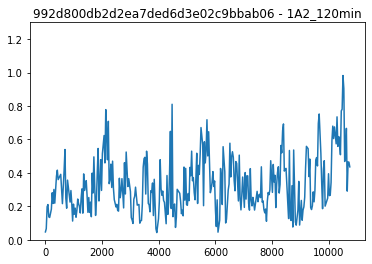

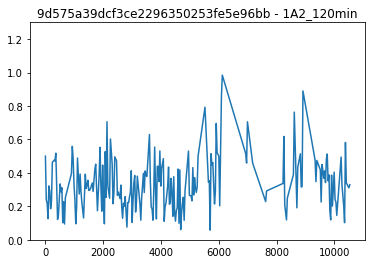

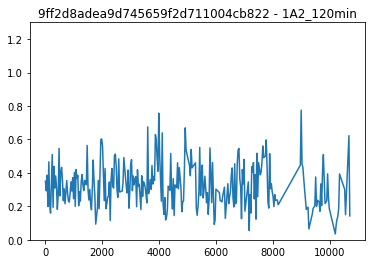

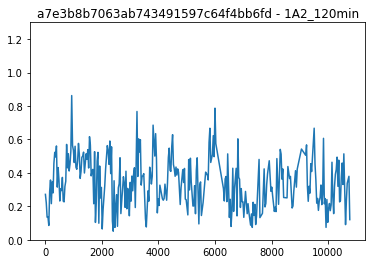

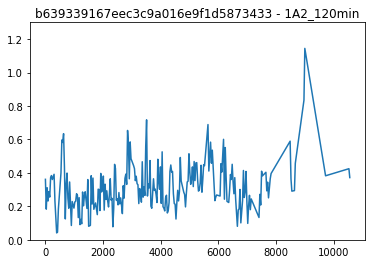

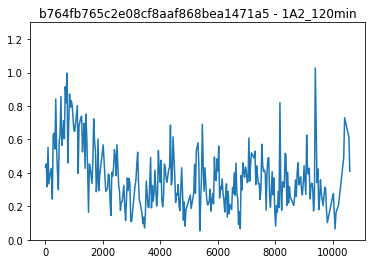

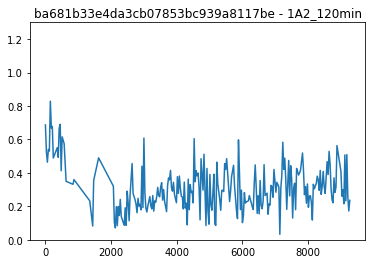

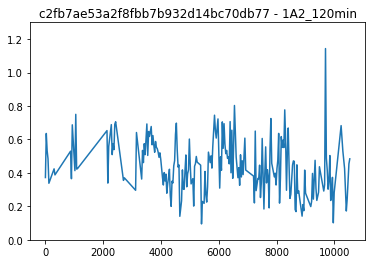

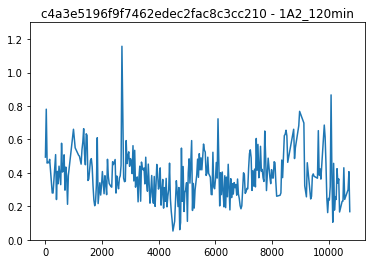

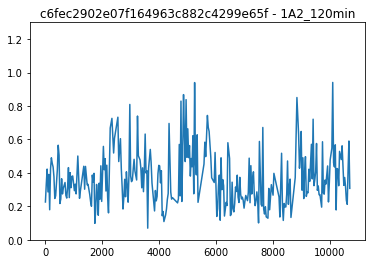

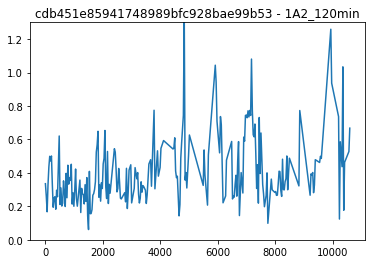

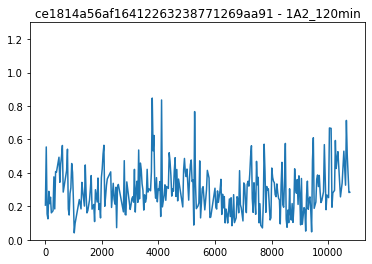

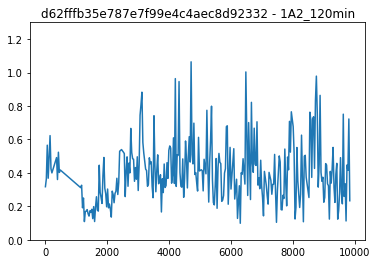

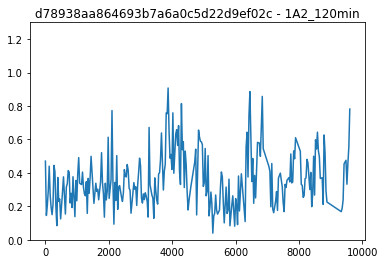

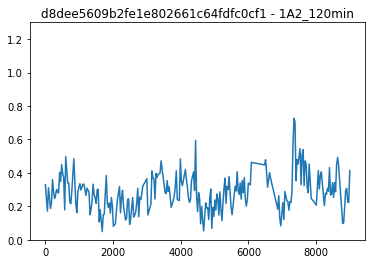

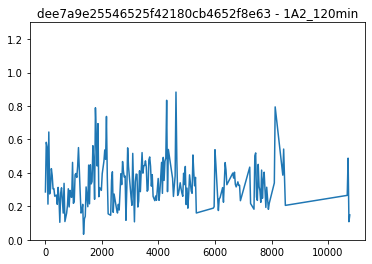

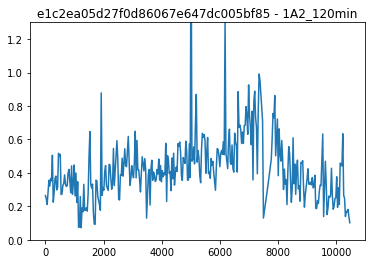

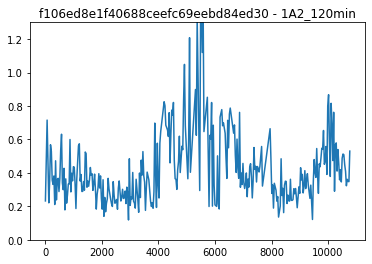

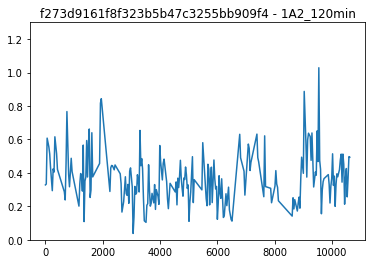

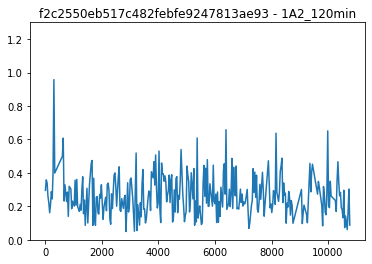

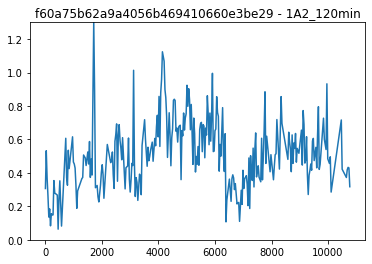

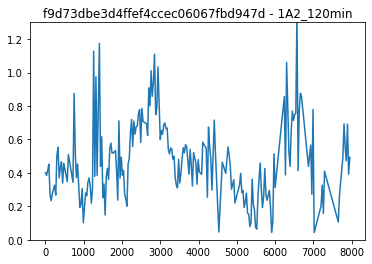

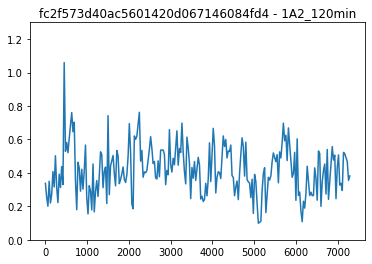

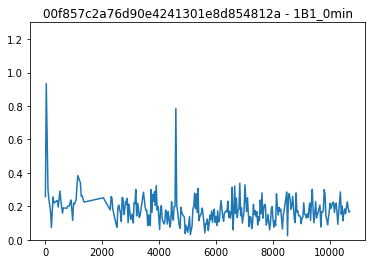

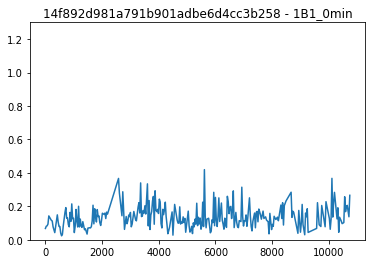

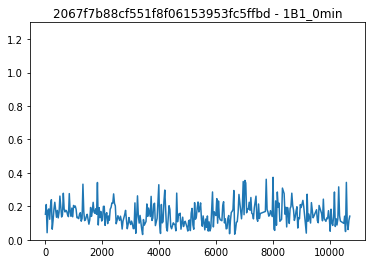

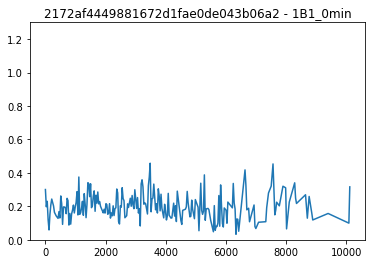

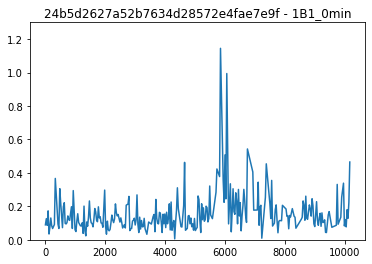

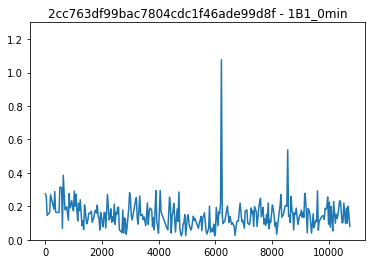

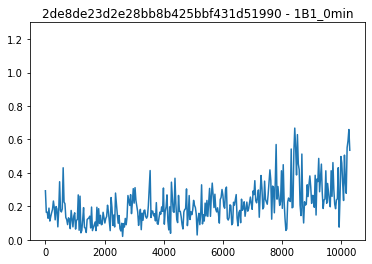

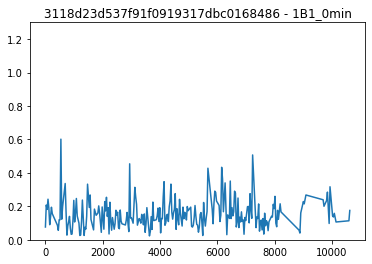

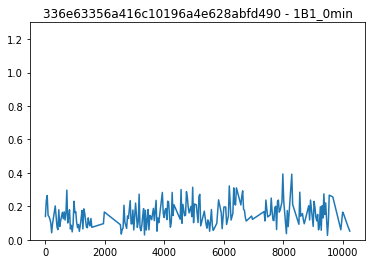

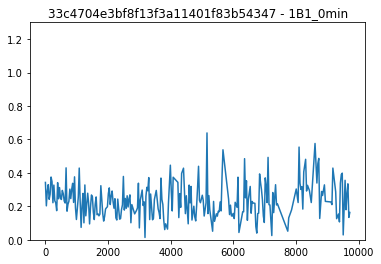

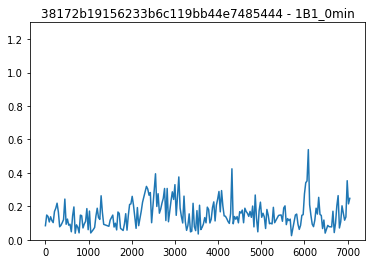

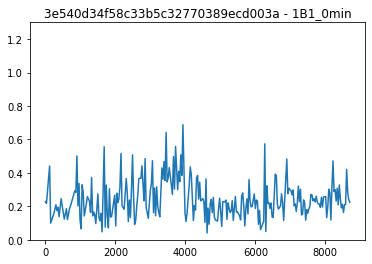

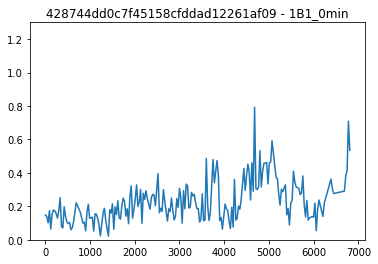

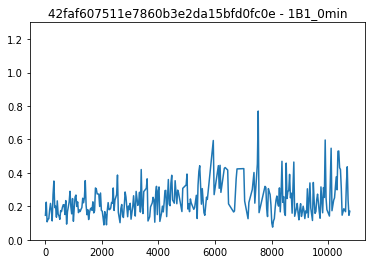

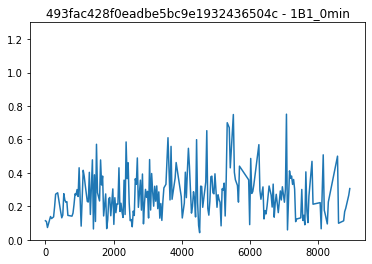

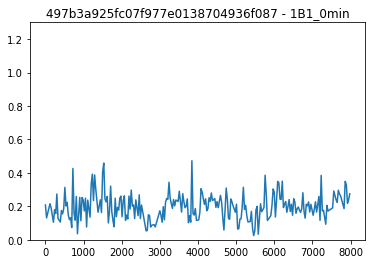

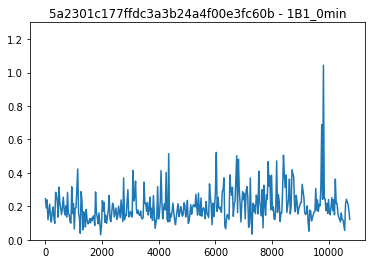

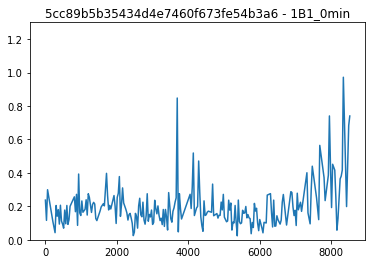

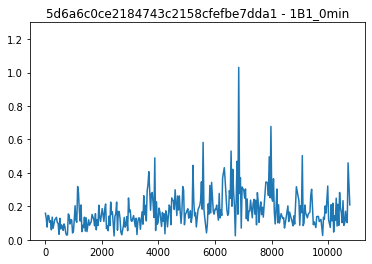

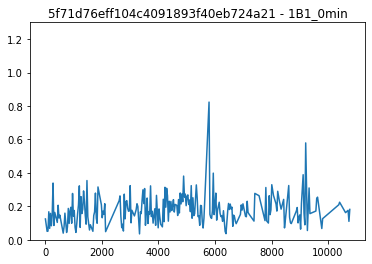

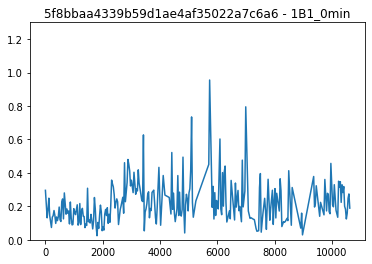

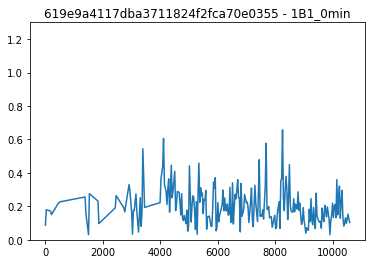

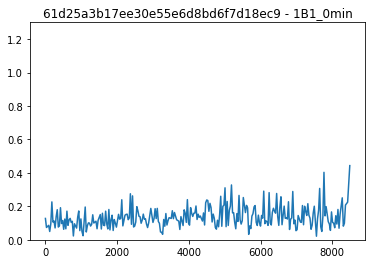

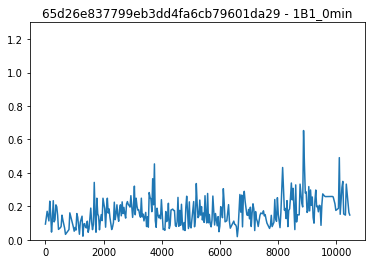

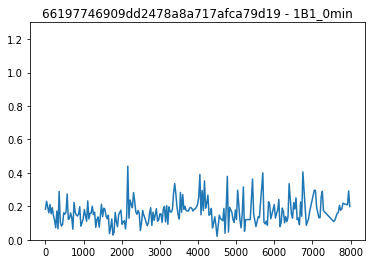

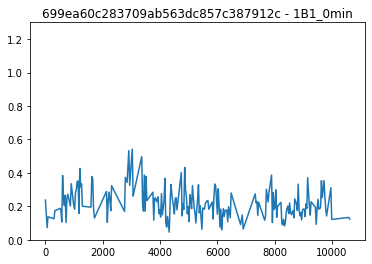

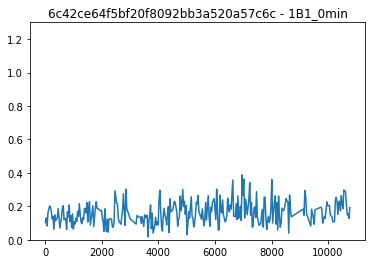

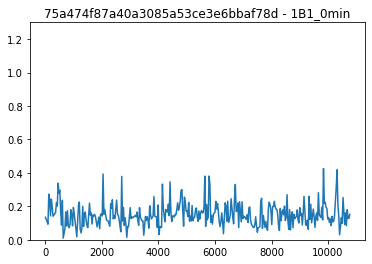

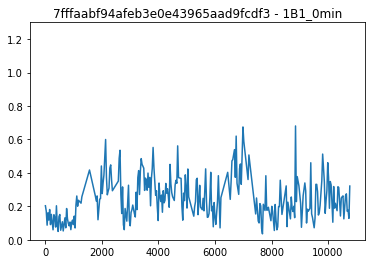

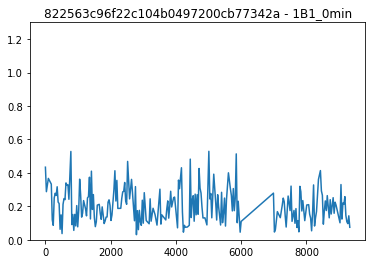

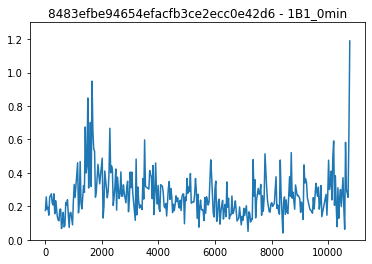

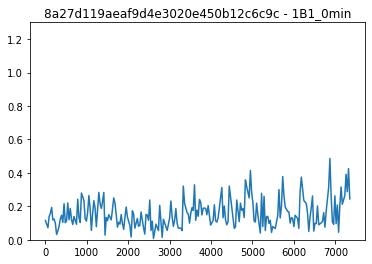

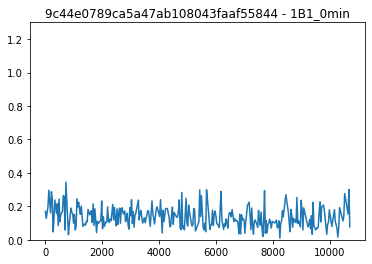

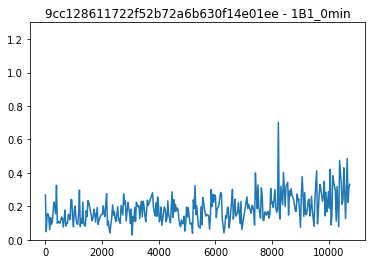

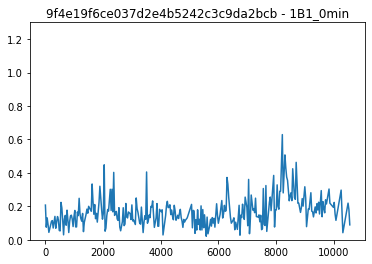

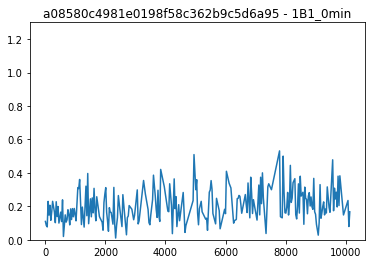

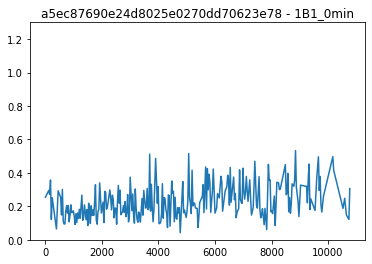

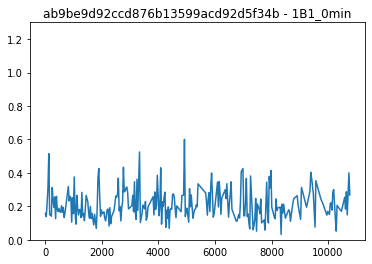

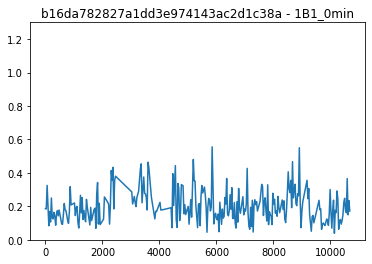

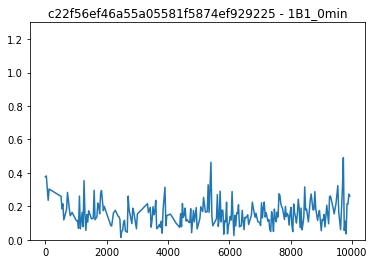

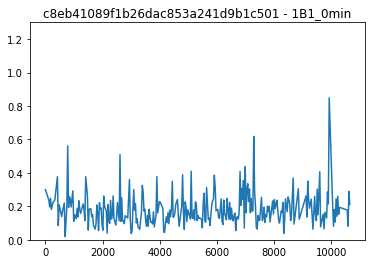

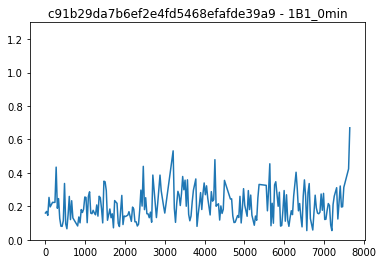

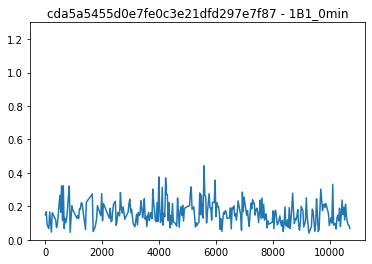

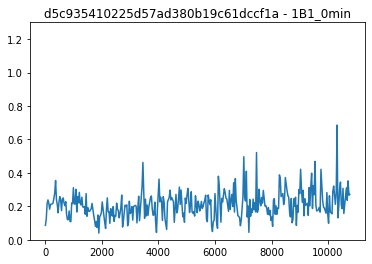

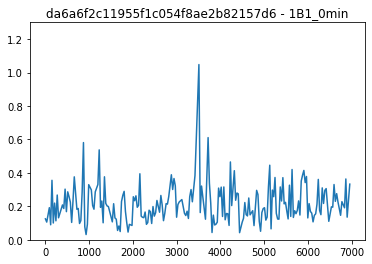

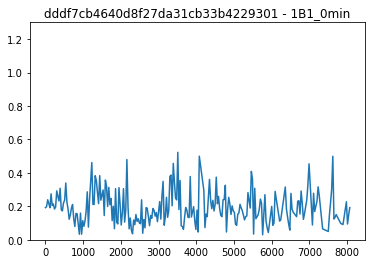

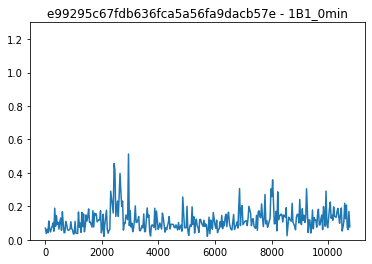

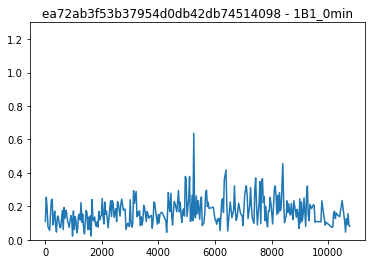

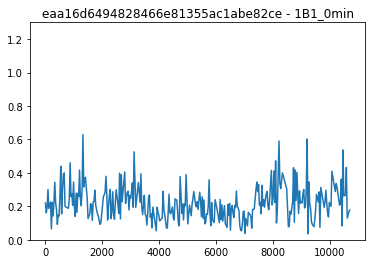

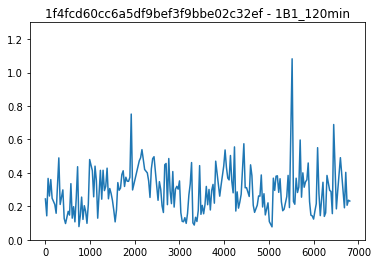

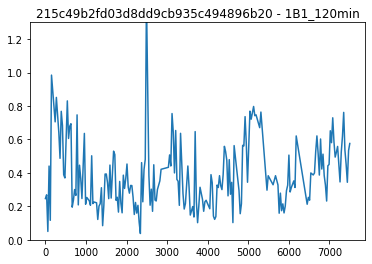

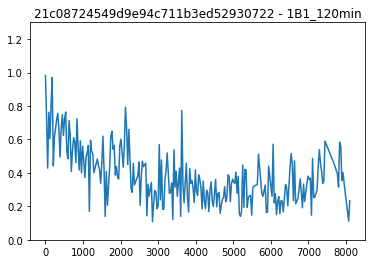

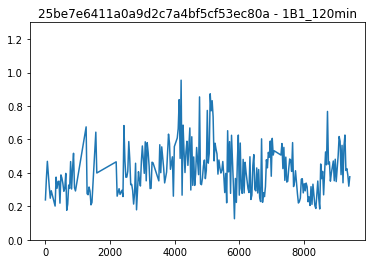

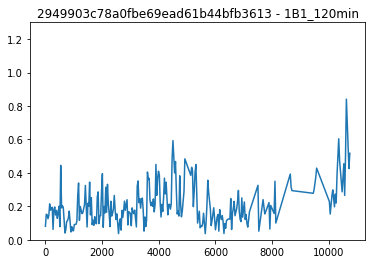

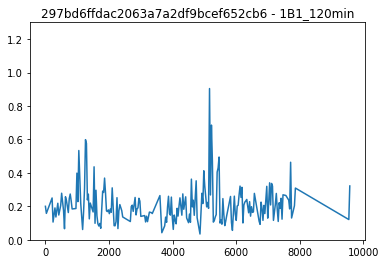

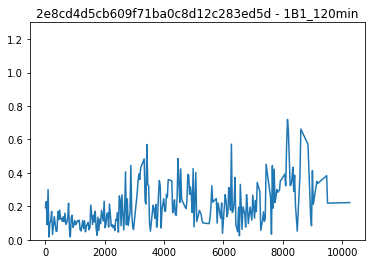

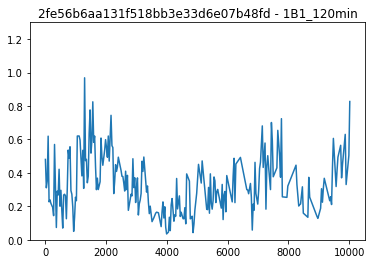

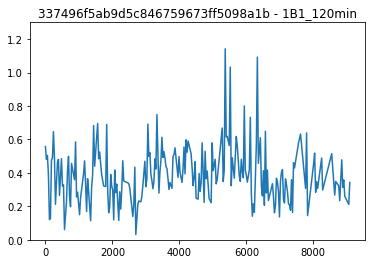

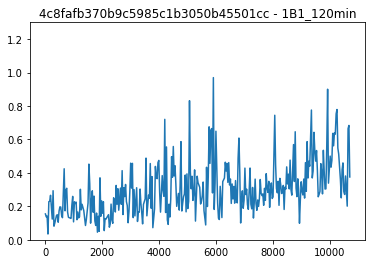

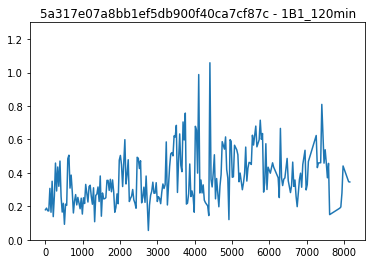

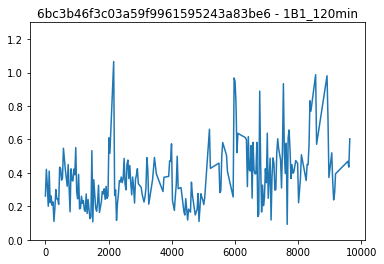

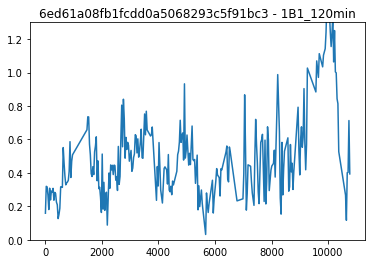

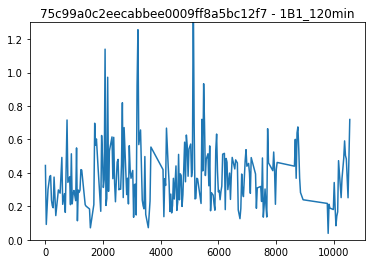

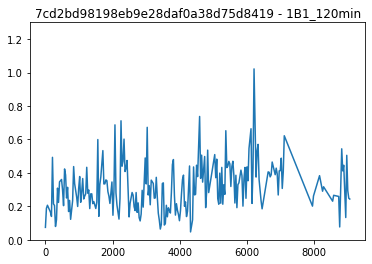

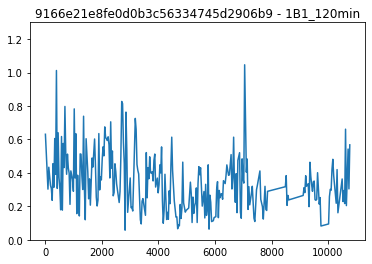

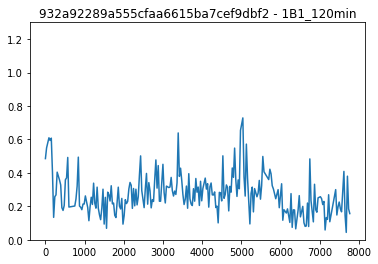

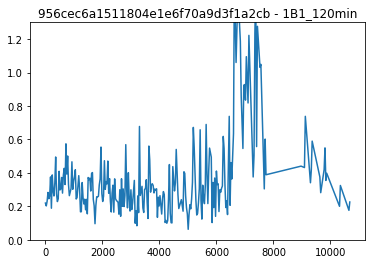

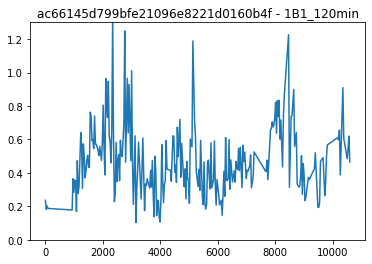

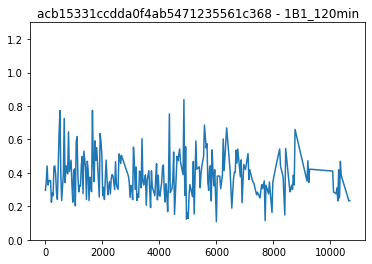

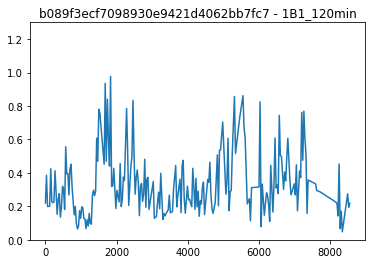

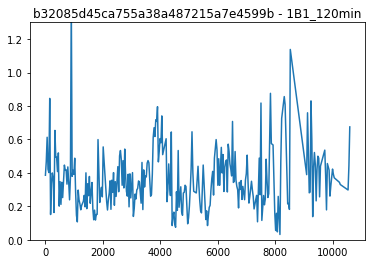

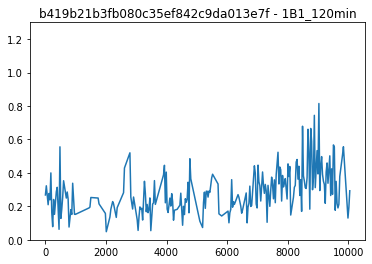

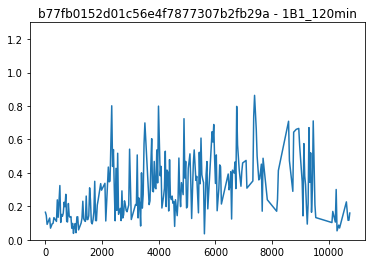

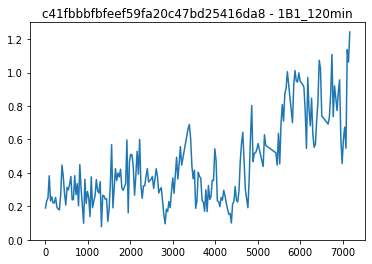

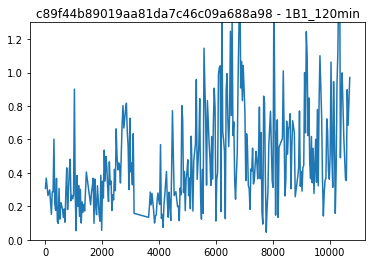

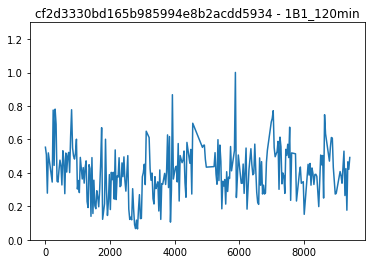

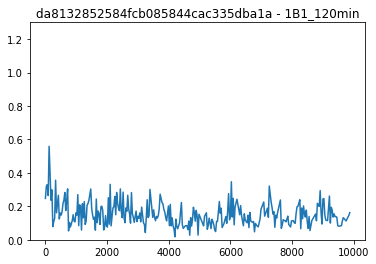

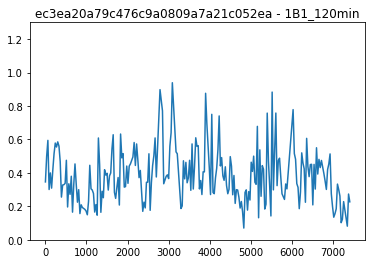

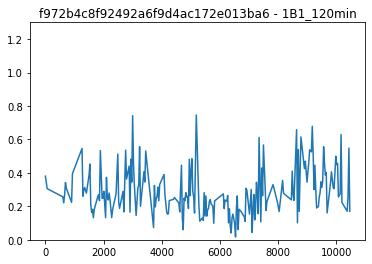

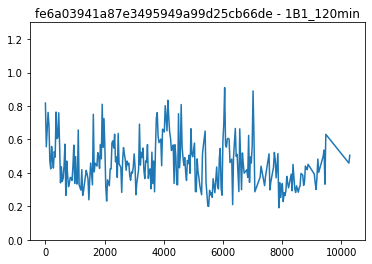

In [38]:
for cond, sub in data.groupby("condition"):
    for uniqueid, a in sub.groupby("uniqueid"):
        if(len(a) > 200):
            minimum = np.min(a.frame)
            fig = plt.figure()
            plt.plot((a.frame - minimum)*30, a.distance)
            plt.title(f"{uniqueid} - {cond}")
            plt.ylim(0,1.3)
            pdf.savefig(fig)

In [39]:
pdf.close()

/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


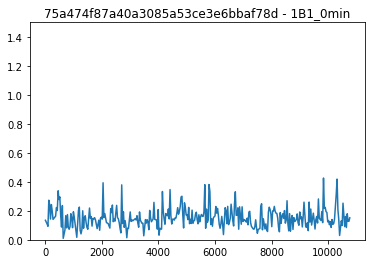

/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


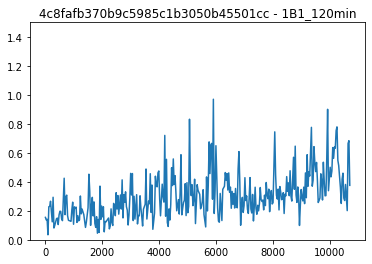

/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


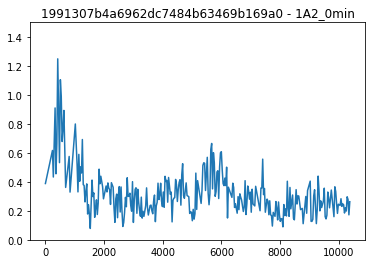

/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


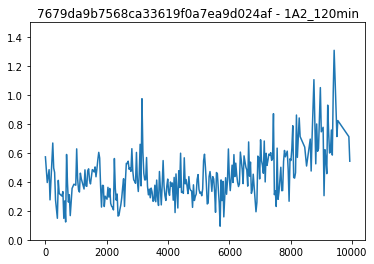

In [40]:
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/"
name = "two_colors_distance_30s"
acquisition = 30
dataset = f"{basedir}/211129_{name}.csv.zip"
data = pd.read_csv(dataset)

# original = []
# for _, sub in data.groupby("uniqueid"):
#     sub, c = fill_gaps(sub, "frame")
#     original.append(sub)

# data = pd.concat(original)

uniqueid = ["75a474f87a40a3085a53ce3e6bbaf78d", "4c8fafb370b9c5985c1b3050b45501cc", "1991307b4a6962dc7484b63469b169a0", "7679da9b7568ca33619f0a7ea9d024af"   ]
res = []
for idx in uniqueid:
    a = data[data.uniqueid == idx]
    minimum = np.min(a.frame)
    a["time"] = (a["frame"] - minimum)*30
    res.append(a[["time", "distance", "condition"]])
    cond = a.condition.unique()[0]
    fig = plt.figure()
    plt.plot((a.time), a.distance)
    plt.title(f"{idx} - {cond}")
    plt.ylim(0,1.5)
    plt.show()
    
    
res = pd.concat(res)
conversion = {"1B1_0min": "'+CTCF +RAD21'", "1B1_120min": "'+CTCF -RAD21'", "1A2_0min": "'-CTCF +RAD21'", "1A2_120min": "'-CTCF -RAD21'"}
res["condition"] = [conversion[x] for x in res["condition"]]
res.to_csv(f"{basedir}/Figure4D.csv", index=False)